# 2. Graphs

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ADFTest
import pmdarima as pm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error

# Reading in the Data

In [2]:
shooting_incidents = pd.read_csv('../data/shooting_incidents.csv')
shooting_offenders = pd.read_csv('../data/shooting_offenders.csv')
shooting_victims = pd.read_csv('../data/shooting_victims.csv')
shooting_weapons = pd.read_csv('../data/shooting_weapons.csv')

countries_count = pd.read_csv('../data/countries_count.csv')
countries_rate = pd.read_csv('../data/countries_rate.csv')

categories = pd.read_csv('../data/categories.csv', header=[0, 1], index_col=0)
ages = pd.read_csv('../data/ages.csv', header=[0, 1], index_col=0)
ttc = pd.read_csv('../data/ttc.csv', header=[0, 1], index_col=0)
types = pd.read_csv('../data/types.csv', header=[0, 1], index_col=0)

# U.S. Shooting Incidents

In [3]:
shooting_incidents.head()

Unnamed: 0  incident_id        date              city               county  \
0          45          543  2022-11-22        Chesapeake      Chesapeake city   
1          46          541  2022-11-20  Colorado Springs       El Paso County   
2          47          542  2022-11-20         Hennessey    Kingfisher County   
3          48          540  2022-11-18          Richmond  Chesterfield County   
4          51          536  2022-11-04          La Plata       Charles County   

  state  num_offenders  num_victims_killed  num_victims_injured  firstcod  \
0    VA              1                   6                    6  Shooting   
1    CO              1                   5                   17  Shooting   
2    OK              1                   4                    1  Shooting   
3    VA              1                   4                    0  Shooting   
4    MD              1                   4                    0  Shooting   

   ... ak_47_pattern  ar_15_pattern    type situation_type  \
0  ...         False          False  Public            NaN   
1  ...         False          False  Public           Hate   
2  ...         False          False   Other            NaN   
3  ...         False          False  Family            NaN   
4  ...         False          False  Family            NaN   

                     location_type             location      gis_code  \
0  Commercial/Retail/Entertainment    Commercial/Retail  5.155002e+10   
1  Commercial/Retail/Entertainment  Bar/Club/Restaurant  8.041000e+09   
2  Commercial/Retail/Entertainment    Commercial/Retail  4.007396e+10   
3          Residence/Other shelter            Residence  5.104110e+10   
4          Residence/Other shelter            Residence  2.401785e+10   

   longitude  latitude                                          narrative  
0  -76.25506  36.70788  A gunman, an employee of the Chesapeake Walmar...  
1 -104.75820  38.88104  Five people were killed and 25 injured at an L...  
2  -98.09125  36.14123  Deputies responding to reports of a hostage si...  
3  -77.46759  37.39593  A woman and her three children were fatally sh...  
4  -76.95524  38.53813  Responding to a 911 call about a shooting, the...  

[5 rows x 21 columns]

# U.S. Shooting Incidents Over Time (2017-2022)

In [4]:
shooting_incidents.insert(3, 'year', pd.DatetimeIndex(shooting_incidents['date']).year)
shooting_incidents.insert(4, 'month', pd.DatetimeIndex(shooting_incidents['date']).month)
incidents_count = shooting_incidents.groupby(by=['year', 'month']).count()

incidents_count = incidents_count['incident_id']
incidents_count.index = [incidents_count.index.map('{0[1]}/{0[0]}'.format)]
incidents_count = incidents_count.reset_index()
incidents_count.head()

level_0  incident_id
0  1/2017            3
1  2/2017            2
2  3/2017            3
3  4/2017            1
4  5/2017            1

# Adding Missing Values
# 2017

In [5]:
incidents_count[incidents_count['level_0'].str.contains('2017')]

level_0  incident_id
0    1/2017            3
1    2/2017            2
2    3/2017            3
3    4/2017            1
4    5/2017            1
5    6/2017            2
6    8/2017            2
7    9/2017            2
8   10/2017            3
9   11/2017            2
10  12/2017            1

In [6]:
incidents_count = pd.concat([incidents_count.iloc[:6], 
                             pd.DataFrame({'level_0': '7/2017', 'incident_id': 0}, index=[7]), 
                             incidents_count.iloc[6:]]).reset_index(drop=True)

incidents_count[incidents_count['level_0'].str.contains('2017')]

level_0  incident_id
0    1/2017            3
1    2/2017            2
2    3/2017            3
3    4/2017            1
4    5/2017            1
5    6/2017            2
6    7/2017            0
7    8/2017            2
8    9/2017            2
9   10/2017            3
10  11/2017            2
11  12/2017            1

# 2018

In [7]:
incidents_count[incidents_count['level_0'].str.contains('2018')]

level_0  incident_id
12   1/2018            2
13   2/2018            3
14   4/2018            1
15   5/2018            3
16   6/2018            2
17   7/2018            2
18   9/2018            1
19  10/2018            3
20  11/2018            3
21  12/2018            1

In [8]:
incidents_count = pd.concat([incidents_count.iloc[:14], 
                             pd.DataFrame({'level_0': '3/2018', 'incident_id': 0}, index=[15]), 
                             incidents_count.iloc[14:]]).reset_index(drop=True)

incidents_count = pd.concat([incidents_count.iloc[:19], 
                             pd.DataFrame({'level_0': '8/2018', 'incident_id': 0}, index=[20]), 
                             incidents_count.iloc[19:]]).reset_index(drop=True)

incidents_count[incidents_count['level_0'].str.contains('2018')]

level_0  incident_id
12   1/2018            2
13   2/2018            3
14   3/2018            0
15   4/2018            1
16   5/2018            3
17   6/2018            2
18   7/2018            2
19   8/2018            0
20   9/2018            1
21  10/2018            3
22  11/2018            3
23  12/2018            1

# 2019

In [9]:
incidents_count[incidents_count['level_0'].str.contains('2019')]

level_0  incident_id
24   1/2019            3
25   2/2019            4
26   4/2019            3
27   5/2019            2
28   6/2019            3
29   7/2019            4
30   8/2019            3
31   9/2019            4
32  10/2019            5
33  11/2019            2
34  12/2019            1

In [10]:
incidents_count = pd.concat([incidents_count.iloc[:26], 
                             pd.DataFrame({'level_0': '3/2019', 'incident_id': 0}, index=[27]), 
                             incidents_count.iloc[26:]]).reset_index(drop=True)

incidents_count[incidents_count['level_0'].str.contains('2019')]

level_0  incident_id
24   1/2019            3
25   2/2019            4
26   3/2019            0
27   4/2019            3
28   5/2019            2
29   6/2019            3
30   7/2019            4
31   8/2019            3
32   9/2019            4
33  10/2019            5
34  11/2019            2
35  12/2019            1

# 2020

In [11]:
incidents_count[incidents_count['level_0'].str.contains('2020')]

level_0  incident_id
36   1/2020            2
37   2/2020            2
38   3/2020            2
39   4/2020            1
40   6/2020            3
41   7/2020            4
42   8/2020            1
43   9/2020            1
44  11/2020            1
45  12/2020            4

In [12]:
incidents_count = pd.concat([incidents_count.iloc[:40], 
                             pd.DataFrame({'level_0': '5/2020', 'incident_id': 0}, index=[41]), 
                             incidents_count.iloc[40:]]).reset_index(drop=True)

incidents_count = pd.concat([incidents_count.iloc[:45], 
                             pd.DataFrame({'level_0': '10/2020', 'incident_id': 0}, index=[46]), 
                             incidents_count.iloc[45:]]).reset_index(drop=True)

incidents_count[incidents_count['level_0'].str.contains('2020')]

level_0  incident_id
36   1/2020            2
37   2/2020            2
38   3/2020            2
39   4/2020            1
40   5/2020            0
41   6/2020            3
42   7/2020            4
43   8/2020            1
44   9/2020            1
45  10/2020            0
46  11/2020            1
47  12/2020            4

# 2021

In [13]:
incidents_count[incidents_count['level_0'].str.contains('2021')]

level_0  incident_id
48   1/2021            2
49   2/2021            1
50   3/2021            5
51   4/2021            4
52   5/2021            3
53   6/2021            3
54   7/2021            2
55   9/2021            4
56  10/2021            2
57  11/2021            3
58  12/2021            2

In [14]:
incidents_count = pd.concat([incidents_count.iloc[:55], 
                             pd.DataFrame({'level_0': '8/2021', 'incident_id': 0}, index=[56]), 
                             incidents_count.iloc[55:]]).reset_index(drop=True)

incidents_count[incidents_count['level_0'].str.contains('2021')]

level_0  incident_id
48   1/2021            2
49   2/2021            1
50   3/2021            5
51   4/2021            4
52   5/2021            3
53   6/2021            3
54   7/2021            2
55   8/2021            0
56   9/2021            4
57  10/2021            2
58  11/2021            3
59  12/2021            2

# 2022

In [15]:
incidents_count[incidents_count['level_0'].str.contains('2022')]

level_0  incident_id
60   1/2022            2
61   2/2022            2
62   4/2022            4
63   5/2022            3
64   6/2022            3
65   7/2022            2
66   8/2022            3
67   9/2022            2
68  10/2022            9
69  11/2022            6

In [16]:
incidents_count = pd.concat([incidents_count.iloc[:62], 
                             pd.DataFrame({'level_0': '3/2022', 'incident_id': 0}, index=[63]), 
                             incidents_count.iloc[62:]]).reset_index(drop=True)

incidents_count = pd.concat([incidents_count, 
                             pd.DataFrame({'level_0': '12/2022', 'incident_id': 0}, index=[71])])

incidents_count[incidents_count['level_0'].str.contains('2022')]

level_0  incident_id
60   1/2022            2
61   2/2022            2
62   3/2022            0
63   4/2022            4
64   5/2022            3
65   6/2022            3
66   7/2022            2
67   8/2022            3
68   9/2022            2
69  10/2022            9
70  11/2022            6
71  12/2022            0

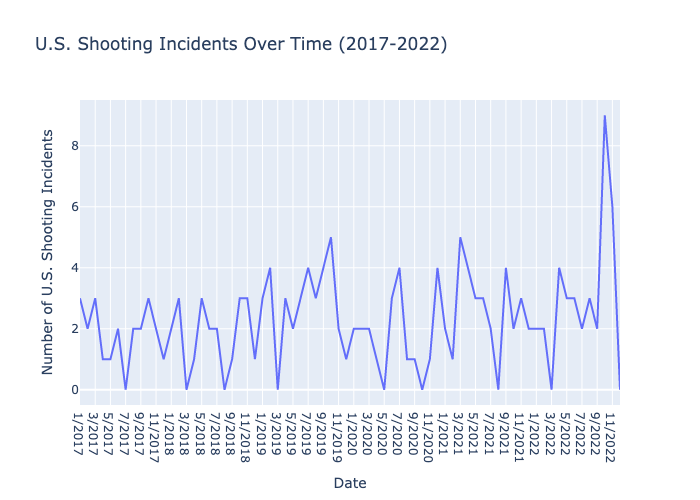

In [17]:
fig = px.line(incidents_count, 
              x='level_0', 
              y='incident_id', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'},
              title='U.S. Shooting Incidents Over Time (2017-2022)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Actual 2023 Incidents Data

In [18]:
actual_2023 = pd.read_csv('../data/mass_killing_incidents_public.csv')
actual_2023 = actual_2023[actual_2023['date'].str.contains('2023')]
actual_2023.head()

incident_id        date           city         county state  \
27          595  2023-12-05         Austin  Travis County    TX   
28          592  2023-12-03  New York City  Queens County    NY   
29          593  2023-12-03         Dallas  Dallas County    TX   
30          594  2023-12-03       Orchards   Clark County    WA   
31          591  2023-11-18        Memphis  Shelby County    TN   

    num_offenders  num_victims_killed  num_victims_injured  firstcod  \
27              1                   6                    3  Shooting   
28              1                   4                    3  Stabbing   
29              1                   4                    1  Shooting   
30              1                   4                    0  Shooting   
31              1                   4                    1  Shooting   

                   secondcod  ak_47_pattern  ar_15_pattern    type  \
27                       NaN          False          False   Other   
28  Smoke inhalation & burns          False          False  Family   
29                       NaN          False          False  Family   
30                       NaN          False          False  Family   
31                       NaN          False          False  Family   

            situation_type            location_type   location  \
27                   Other                 Multiple   Multiple   
28                     NaN  Residence/Other shelter  Residence   
29  Interpersonal conflict  Residence/Other shelter  Residence   
30            Family issue  Residence/Other shelter  Residence   
31                     NaN                 Multiple   Multiple   

    census_tract_geoid  longitude  latitude  \
27        4.845300e+10  -97.78798  30.18896   
28        3.608110e+10  -73.75726  40.59853   
29        4.811301e+10  -96.65376  32.68004   
30        5.301104e+10 -122.55414  45.68909   
31        4.715702e+10  -90.10232  35.04819   

                                            narrative  
27  Shane James, 34, was arrested for fatally shoo...  
28  Courtney Gordon, 38, fatally stabbed four rela...  
29  Byron Carrillo, 21, shot five people at his ne...  
30  Four people were fatally shot in their home by...  
31  Fifty-two year-old Mavis Christian, Jr., shot ...

In [19]:
actual_2023.insert(3, 'year', pd.DatetimeIndex(actual_2023['date']).year)
actual_2023.insert(4, 'month', pd.DatetimeIndex(actual_2023['date']).month)
actual_2023 = actual_2023.groupby(by=['year', 'month']).count()

actual_2023 = actual_2023['incident_id']
actual_2023.index = [actual_2023.index.map('{0[1]}/{0[0]}'.format)]
actual_2023 = actual_2023.reset_index()
actual_2023

level_0  incident_id
0    1/2023            7
1    2/2023            2
2    3/2023            7
3    4/2023            6
4    5/2023            4
5    6/2023            2
6    7/2023            4
7    8/2023            2
8    9/2023            1
9   10/2023            2
10  11/2023            1
11  12/2023            4

# Forecasting with Regression Models (2023 Prediction)
# Using Linear Regression

In [20]:
X = np.arange(72).reshape(-1, 1)
y = incidents_count['incident_id']

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(np.arange(72, 84).reshape(-1, 1))
y_pred

array([2.93075117, 2.94826034, 2.9657695 , 2.98327867, 3.00078783,
       3.018297  , 3.03580616, 3.05331533, 3.07082449, 3.08833365,
       3.10584282, 3.12335198])

In [21]:
forecast = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                     '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                         'incident_id': y_pred, 
                         'Legend': ['Forecasted Data'] * 12})

new_incidents_count = pd.concat([incidents_count, actual_2023]).reset_index()
new_incidents_count['Legend'] = ['Actual Data'] * 84

## Writing to csv

In [22]:
incidents_count_linear = pd.concat([new_incidents_count, forecast])
#incidents_count_linear.to_csv('incidents_count_linear.csv')

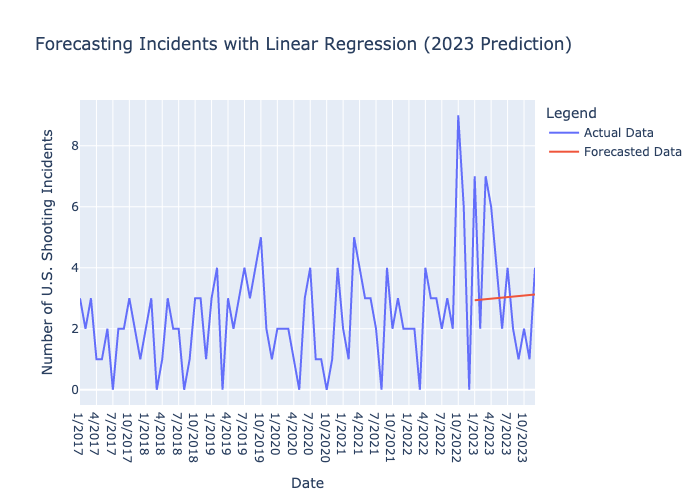

In [23]:
fig = px.line(incidents_count_linear, 
              x='level_0', 
              y='incident_id', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'}, 
              title='Forecasting Incidents with Linear Regression (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Using Polynomial Regression

In [24]:
poly_features = PolynomialFeatures(7)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

new_poly = poly_features.transform(np.arange(72, 84).reshape(-1, 1))
y_pred_poly = poly_model.predict(new_poly)
y_pred_poly

array([3.92340907, 3.98777597, 4.02131043, 4.01616864, 3.96347281,
       3.85322171, 3.67419633, 3.41386038, 3.05825564, 2.59189184,
       1.9976311 , 1.25656679])

In [25]:
forecast = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                     '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                         'incident_id': y_pred_poly, 
                         'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [26]:
incidents_count_polynomial = pd.concat([new_incidents_count, forecast])
#incidents_count_polynomial.to_csv('incidents_count_polynomial.csv')

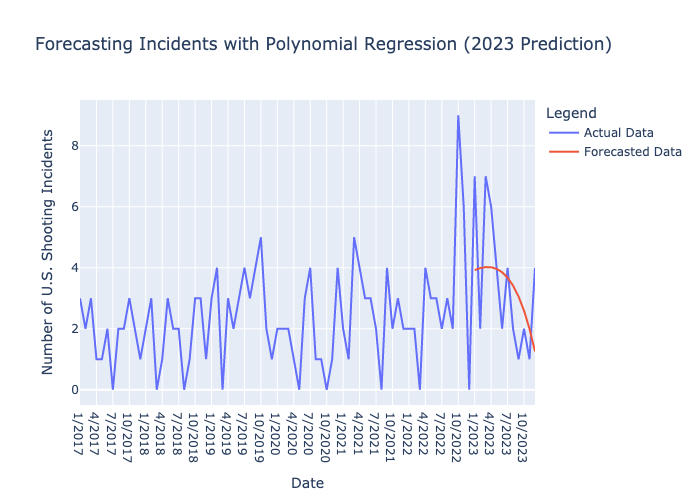

In [27]:
fig = px.line(incidents_count_polynomial, 
              x='level_0', 
              y='incident_id', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'}, 
              title='Forecasting Incidents with Polynomial Regression (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Forecasting with ARIMA (2023 Prediction)
# Using Manual ARIMA

In [28]:
model = ARIMA(incidents_count['incident_id'], order=(1,0,1))
model_fit = model.fit()
model_fit.predict(72, 83)

72    2.665523
73    2.000545
74    2.520554
75    2.113910
76    2.431903
77    2.183235
78    2.377692
79    2.225628
80    2.344541
81    2.251552
82    2.324269
83    2.267404
Name: predicted_mean, dtype: float64

In [29]:
forecast = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                     '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                         'incident_id': model_fit.predict(72, 83).values, 
                         'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [30]:
incidents_count_arima = pd.concat([new_incidents_count, forecast])
#incidents_count_arima.to_csv('incidents_count_arima.csv')

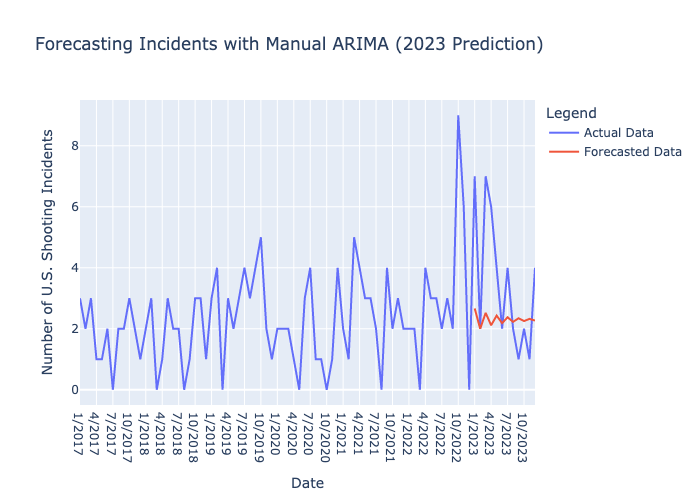

In [31]:
fig = px.line(incidents_count_arima, 
              x='level_0', 
              y='incident_id', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'}, 
              title='Forecasting Incidents with Manual ARIMA (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Using Auto ARIMA

In [32]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(incidents_count['incident_id'])

(0.14738381454764904, True)

In [33]:
auto_model = pm.auto_arima(incidents_count['incident_id'], seasonal=False, stationary=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -133.024
Date:                Mon, 30 Sep 2024   AIC                            272.048
Time:                        12:52:45   BIC                            278.878
Sample:                             0   HQIC                           274.767
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2857      0.248      9.220      0.000       1.800       2.772
ma.L1          0.2188      0.116      1.889      0.059      -0.008       0.446
sigma2         2.3550      0.267      8.835      0.000       1.833       2.877
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                56.15
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             1.09
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
auto_model.predict(12)

72    1.679329
73    2.285735
74    2.285735
75    2.285735
76    2.285735
77    2.285735
78    2.285735
79    2.285735
80    2.285735
81    2.285735
82    2.285735
83    2.285735
dtype: float64

In [35]:
forecast = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                     '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                         'incident_id': auto_model.predict(12).values, 
                         'Legend': ['Forecasted Data'] * 12})
forecast.index = range(72, 84)

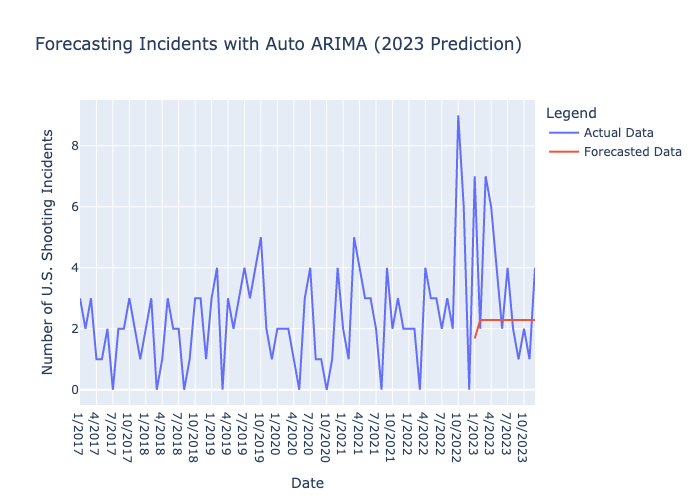

In [36]:
fig = px.line(pd.concat([new_incidents_count, forecast]), 
              x='level_0', 
              y='incident_id', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'}, 
              title='Forecasting Incidents with Auto ARIMA (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Forecasting with Exponential Smoothing (2023 Prediction)
# Using Simple Exponential Smoothing

In [37]:
ses_fit = SimpleExpSmoothing(incidents_count['incident_id'], initialization_method='estimated').fit()
ses_fit.predict(72, 83)

72    2.291668
73    2.291668
74    2.291668
75    2.291668
76    2.291668
77    2.291668
78    2.291668
79    2.291668
80    2.291668
81    2.291668
82    2.291668
83    2.291668
dtype: float64

In [38]:
forecast = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                     '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                         'incident_id': ses_fit.predict(72, 83).values, 
                         'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [39]:
incidents_count_ses = pd.concat([new_incidents_count, forecast])
#incidents_count_ses.to_csv('incidents_count_ses.csv')

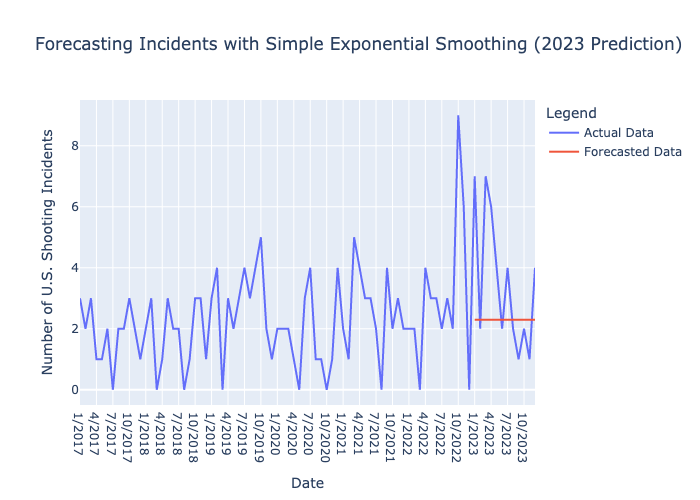

In [40]:
fig = px.line(incidents_count_ses, 
              x='level_0', 
              y='incident_id', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'}, 
              title='Forecasting Incidents with Simple Exponential Smoothing (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Using Holt's Method

In [41]:
holts_fit = Holt(incidents_count['incident_id'], initialization_method='estimated').fit()
holts_fit.predict(72, 83)

72    2.930750
73    2.948259
74    2.965768
75    2.983278
76    3.000787
77    3.018296
78    3.035805
79    3.053314
80    3.070823
81    3.088332
82    3.105842
83    3.123351
dtype: float64

In [42]:
forecast = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                     '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                         'incident_id': holts_fit.predict(72, 83).values, 
                         'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [43]:
incidents_count_holts = pd.concat([new_incidents_count, forecast])
#incidents_count_holts.to_csv('incidents_count_holts.csv')

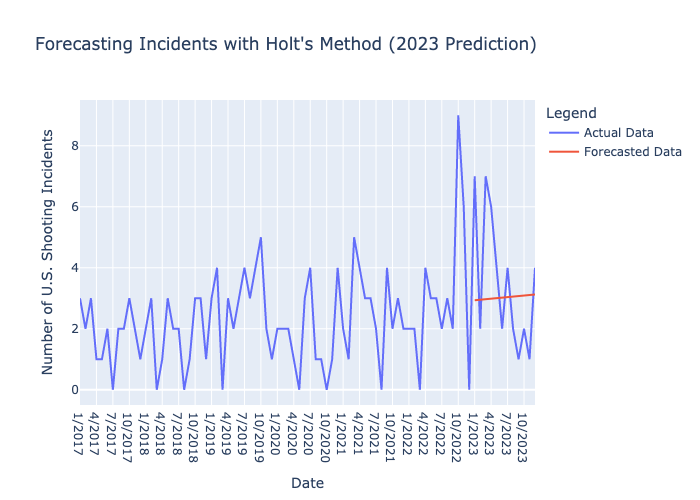

In [44]:
fig = px.line(incidents_count_holts, 
              x='level_0', 
              y='incident_id', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'incident_id': 'Number of U.S. Shooting Incidents'}, 
              title='Forecasting Incidents with Holt\'s Method (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# RMSE

In [45]:
print('Linear Regression: ', mean_squared_error(actual_2023['incident_id'], y_pred))
print('Polynomial Regression: ', mean_squared_error(actual_2023['incident_id'], y_pred_poly))

print('Manual ARIMA: ', mean_squared_error(actual_2023['incident_id'], model_fit.predict(72, 83)))
print('Auto ARIMA: ', mean_squared_error(actual_2023['incident_id'], auto_model.predict(12)))

print('SES: ', mean_squared_error(actual_2023['incident_id'], ses_fit.predict(72, 83)))
print('Holt\'s Method: ', mean_squared_error(actual_2023['incident_id'], holts_fit.predict(72, 83)))

Linear Regression:  4.798664465358954
Polynomial Regression:  3.7395169568827753
Manual ARIMA:  5.479729603815607
Auto ARIMA:  6.3982094608383875
SES:  5.8767333484826905
Holt's Method:  4.798665313303252


# Total Incidents in 2023

In [46]:
actual_2023['incident_id'].sum()

42

# Number of U.S. Shooting Incidents by Year

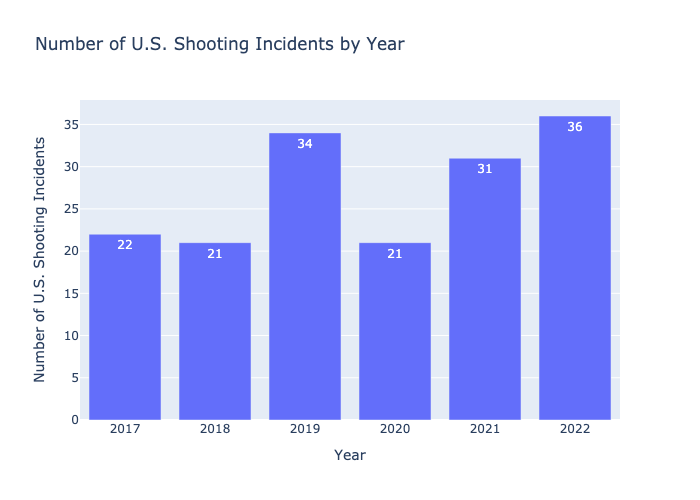

In [47]:
incidents_year_count = shooting_incidents.groupby(by='year').count()

fig = px.bar(incidents_year_count['incident_id'], 
             labels={'year': 'Year', 
                     'value': 'Number of U.S. Shooting Incidents'}, 
             title='Number of U.S. Shooting Incidents by Year', 
             text_auto=True)

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. Shooting Victims Over Time (2017-2022)

In [48]:
victims_sum = shooting_incidents.groupby(by=['year', 'month']).sum()

victims_sum = victims_sum[['num_victims_killed', 'num_victims_injured']]
victims_sum.index = [victims_sum.index.map('{0[1]}/{0[0]}'.format)]
victims_sum = victims_sum.reset_index()
victims_sum.head()

level_0  num_victims_killed  num_victims_injured
0  1/2017                  13                    6
1  2/2017                   8                    0
2  3/2017                  12                    1
3  4/2017                   4                    0
4  5/2017                   8                    1

# Adding Missing Values
# 2017

In [49]:
victims_sum[victims_sum['level_0'].str.contains('2017')]

level_0  num_victims_killed  num_victims_injured
0    1/2017                  13                    6
1    2/2017                   8                    0
2    3/2017                  12                    1
3    4/2017                   4                    0
4    5/2017                   8                    1
5    6/2017                  10                    0
6    8/2017                   8                    0
7    9/2017                  12                    1
8   10/2017                  68                  868
9   11/2017                  30                   38
10  12/2017                   4                    0

In [50]:
victims_sum = pd.concat([victims_sum.iloc[:6], 
                         pd.DataFrame({'level_0': '7/2017', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[7]), 
                         victims_sum.iloc[6:]]).reset_index(drop=True)

victims_sum[victims_sum['level_0'].str.contains('2017')]

level_0  num_victims_killed  num_victims_injured
0    1/2017                  13                    6
1    2/2017                   8                    0
2    3/2017                  12                    1
3    4/2017                   4                    0
4    5/2017                   8                    1
5    6/2017                  10                    0
6    7/2017                   0                    0
7    8/2017                   8                    0
8    9/2017                  12                    1
9   10/2017                  68                  868
10  11/2017                  30                   38
11  12/2017                   4                    0

# 2018

In [51]:
victims_sum[victims_sum['level_0'].str.contains('2018')]

level_0  num_victims_killed  num_victims_injured
12   1/2018                   8                    1
13   2/2018                  25                   17
14   4/2018                   4                    4
15   5/2018                  20                   14
16   6/2018                  10                    2
17   7/2018                   8                    0
18   9/2018                   5                    0
19  10/2018                  19                    7
20  11/2018                  20                   12
21  12/2018                   4                    1

In [52]:
victims_sum = pd.concat([victims_sum.iloc[:14], 
                         pd.DataFrame({'level_0': '3/2018', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[15]), 
                         victims_sum.iloc[14:]]).reset_index(drop=True)

victims_sum = pd.concat([victims_sum.iloc[:19], 
                         pd.DataFrame({'level_0': '8/2018', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[20]), 
                         victims_sum.iloc[19:]]).reset_index(drop=True)

victims_sum[victims_sum['level_0'].str.contains('2018')]

level_0  num_victims_killed  num_victims_injured
12   1/2018                   8                    1
13   2/2018                  25                   17
14   3/2018                   0                    0
15   4/2018                   4                    4
16   5/2018                  20                   14
17   6/2018                  10                    2
18   7/2018                   8                    0
19   8/2018                   0                    0
20   9/2018                   5                    0
21  10/2018                  19                    7
22  11/2018                  20                   12
23  12/2018                   4                    1

# 2019

In [53]:
victims_sum[victims_sum['level_0'].str.contains('2019')]

level_0  num_victims_killed  num_victims_injured
24   1/2019                  14                    1
25   2/2019                  17                    6
26   4/2019                  12                    2
27   5/2019                  16                    6
28   6/2019                  13                    2
29   7/2019                  17                    4
30   8/2019                  39                   72
31   9/2019                  17                    2
32  10/2019                  22                   14
33  11/2019                   9                    6
34  12/2019                   4                    3

In [54]:
victims_sum = pd.concat([victims_sum.iloc[:26], 
                         pd.DataFrame({'level_0': '3/2019', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[27]), 
                         victims_sum.iloc[26:]]).reset_index(drop=True)

victims_sum[victims_sum['level_0'].str.contains('2019')]

level_0  num_victims_killed  num_victims_injured
24   1/2019                  14                    1
25   2/2019                  17                    6
26   3/2019                   0                    0
27   4/2019                  12                    2
28   5/2019                  16                    6
29   6/2019                  13                    2
30   7/2019                  17                    4
31   8/2019                  39                   72
32   9/2019                  17                    2
33  10/2019                  22                   14
34  11/2019                   9                    6
35  12/2019                   4                    3

# 2020

In [55]:
victims_sum[victims_sum['level_0'].str.contains('2020')]

level_0  num_victims_killed  num_victims_injured
36   1/2020                   8                    1
37   2/2020                   9                    0
38   3/2020                  10                    2
39   4/2020                   5                    0
40   6/2020                  16                    5
41   7/2020                  16                    7
42   8/2020                   4                    0
43   9/2020                   7                    0
44  11/2020                   4                    0
45  12/2020                  17                    0

In [56]:
victims_sum = pd.concat([victims_sum.iloc[:40], 
                         pd.DataFrame({'level_0': '5/2020', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[41]), 
                         victims_sum.iloc[40:]]).reset_index(drop=True)

victims_sum = pd.concat([victims_sum.iloc[:45], 
                         pd.DataFrame({'level_0': '10/2020', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[46]), 
                         victims_sum.iloc[45:]]).reset_index(drop=True)

victims_sum[victims_sum['level_0'].str.contains('2020')]

level_0  num_victims_killed  num_victims_injured
36   1/2020                   8                    1
37   2/2020                   9                    0
38   3/2020                  10                    2
39   4/2020                   5                    0
40   5/2020                   0                    0
41   6/2020                  16                    5
42   7/2020                  16                    7
43   8/2020                   4                    0
44   9/2020                   7                    0
45  10/2020                   0                    0
46  11/2020                   4                    0
47  12/2020                  17                    0

# 2021

In [57]:
victims_sum[victims_sum['level_0'].str.contains('2021')]

level_0  num_victims_killed  num_victims_injured
48   1/2021                  10                    4
49   2/2021                   6                    2
50   3/2021                  30                    4
51   4/2021                  22                    4
52   5/2021                  19                    1
53   6/2021                  13                    5
54   7/2021                   8                    1
55   9/2021                  16                    2
56  10/2021                   8                    0
57  11/2021                  13                    7
58  12/2021                   9                    5

In [58]:
victims_sum = pd.concat([victims_sum.iloc[:55], 
                         pd.DataFrame({'level_0': '8/2021', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[56]), 
                         victims_sum.iloc[55:]]).reset_index(drop=True)

victims_sum[victims_sum['level_0'].str.contains('2021')]

level_0  num_victims_killed  num_victims_injured
48   1/2021                  10                    4
49   2/2021                   6                    2
50   3/2021                  30                    4
51   4/2021                  22                    4
52   5/2021                  19                    1
53   6/2021                  13                    5
54   7/2021                   8                    1
55   8/2021                   0                    0
56   9/2021                  16                    2
57  10/2021                   8                    0
58  11/2021                  13                    7
59  12/2021                   9                    5

# 2022

In [59]:
victims_sum[victims_sum['level_0'].str.contains('2022')]

level_0  num_victims_killed  num_victims_injured
60   1/2022                  10                    1
61   2/2022                   9                    2
62   4/2022                  18                   10
63   5/2022                  35                   20
64   6/2022                  13                    0
65   7/2022                  11                   30
66   8/2022                  12                    0
67   9/2022                   9                    0
68  10/2022                  42                    3
69  11/2022                  27                   25

In [60]:
victims_sum = pd.concat([victims_sum.iloc[:62], 
                         pd.DataFrame({'level_0': '3/2022', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[63]), 
                         victims_sum.iloc[62:]]).reset_index(drop=True)

victims_sum = pd.concat([victims_sum, 
                         pd.DataFrame({'level_0': '12/2022', 'num_victims_killed': 0, 'num_victims_injured': 0}, 
                                        index=[71])])

victims_sum[victims_sum['level_0'].str.contains('2022')]

level_0  num_victims_killed  num_victims_injured
60   1/2022                  10                    1
61   2/2022                   9                    2
62   3/2022                   0                    0
63   4/2022                  18                   10
64   5/2022                  35                   20
65   6/2022                  13                    0
66   7/2022                  11                   30
67   8/2022                  12                    0
68   9/2022                   9                    0
69  10/2022                  42                    3
70  11/2022                  27                   25
71  12/2022                   0                    0

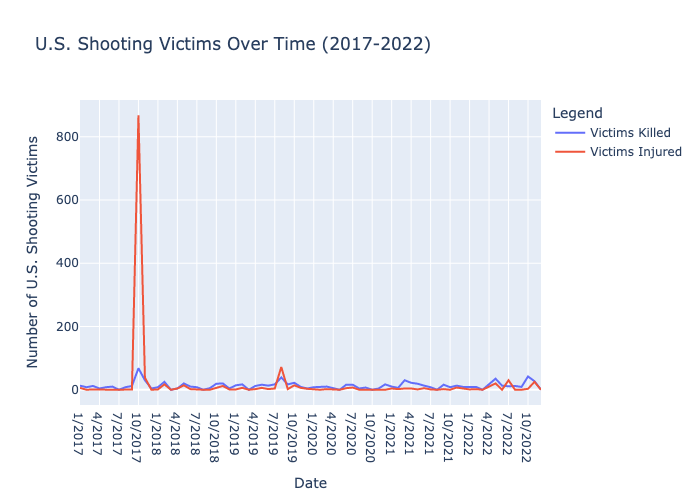

In [61]:
fig = px.line(victims_sum, 
              x='level_0', 
              y=['num_victims_killed', 'num_victims_injured'], 
              labels={'level_0': 'Date', 
                      'value': 'Number of U.S. Shooting Victims', 
                      'variable': 'Legend'},
              title='U.S. Shooting Victims Over Time (2017-2022)')

newnames = {'num_victims_killed': 'Victims Killed', 'num_victims_injured': 'Victims Injured'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Actual 2023 Victims Data

In [62]:
actual_2023 = pd.read_csv('../data/mass_killing_incidents_public.csv')
actual_2023 = actual_2023[actual_2023['date'].str.contains('2023')]
actual_2023.head()

incident_id        date           city         county state  \
27          595  2023-12-05         Austin  Travis County    TX   
28          592  2023-12-03  New York City  Queens County    NY   
29          593  2023-12-03         Dallas  Dallas County    TX   
30          594  2023-12-03       Orchards   Clark County    WA   
31          591  2023-11-18        Memphis  Shelby County    TN   

    num_offenders  num_victims_killed  num_victims_injured  firstcod  \
27              1                   6                    3  Shooting   
28              1                   4                    3  Stabbing   
29              1                   4                    1  Shooting   
30              1                   4                    0  Shooting   
31              1                   4                    1  Shooting   

                   secondcod  ak_47_pattern  ar_15_pattern    type  \
27                       NaN          False          False   Other   
28  Smoke inhalation & burns          False          False  Family   
29                       NaN          False          False  Family   
30                       NaN          False          False  Family   
31                       NaN          False          False  Family   

            situation_type            location_type   location  \
27                   Other                 Multiple   Multiple   
28                     NaN  Residence/Other shelter  Residence   
29  Interpersonal conflict  Residence/Other shelter  Residence   
30            Family issue  Residence/Other shelter  Residence   
31                     NaN                 Multiple   Multiple   

    census_tract_geoid  longitude  latitude  \
27        4.845300e+10  -97.78798  30.18896   
28        3.608110e+10  -73.75726  40.59853   
29        4.811301e+10  -96.65376  32.68004   
30        5.301104e+10 -122.55414  45.68909   
31        4.715702e+10  -90.10232  35.04819   

                                            narrative  
27  Shane James, 34, was arrested for fatally shoo...  
28  Courtney Gordon, 38, fatally stabbed four rela...  
29  Byron Carrillo, 21, shot five people at his ne...  
30  Four people were fatally shot in their home by...  
31  Fifty-two year-old Mavis Christian, Jr., shot ...

In [63]:
actual_2023.insert(3, 'year', pd.DatetimeIndex(actual_2023['date']).year)
actual_2023.insert(4, 'month', pd.DatetimeIndex(actual_2023['date']).month)
actual_2023 = actual_2023.groupby(by=['year', 'month']).sum()

actual_2023 = actual_2023[['num_victims_killed', 'num_victims_injured']]
actual_2023.index = [actual_2023.index.map('{0[1]}/{0[0]}'.format)]
actual_2023 = actual_2023.reset_index()
actual_2023

level_0  num_victims_killed  num_victims_injured
0    1/2023                  43                   11
1    2/2023                  10                    1
2    3/2023                  30                    0
3    4/2023                  28                   43
4    5/2023                  20                    8
5    6/2023                   9                    1
6    7/2023                  19                   13
7    8/2023                   8                    0
8    9/2023                   5                    0
9   10/2023                  23                   13
10  11/2023                   4                    1
11  12/2023                  18                    7

# Forecasting with Regression Models (2023 Prediction)
# Using Linear Regression

In [64]:
X = np.arange(72).reshape(-1, 1)
y = victims_sum['num_victims_killed']

model = LinearRegression()
model.fit(X, y)

y_pred_killed = model.predict(np.arange(72, 84).reshape(-1, 1))
y_pred_killed

array([13.46635368, 13.48674084, 13.507128  , 13.52751517, 13.54790233,
       13.56828949, 13.58867666, 13.60906382, 13.62945098, 13.64983815,
       13.67022531, 13.69061247])

In [65]:
y = victims_sum['num_victims_injured']

model = LinearRegression()
model.fit(X, y)

y_pred_injured = model.predict(np.arange(72, 84).reshape(-1, 1))
y_pred_injured

array([ -9.16353678,  -9.88339014, -10.60324351, -11.32309688,
       -12.04295024, -12.76280361, -13.48265698, -14.20251034,
       -14.92236371, -15.64221708, -16.36207044, -17.08192381])

In [66]:
forecast_killed = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_killed': y_pred_killed, 
                                'Legend': ['Forecasted Data'] * 12})

forecast_injured = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                             '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                 'num_victims_injured': y_pred_injured, 
                                 'Legend': ['Forecasted Data'] * 12})

new_victims_sum = pd.concat([victims_sum, 
                             actual_2023]).reset_index()
new_victims_sum['Legend'] = ['Actual Data'] * 84

actual_killed = new_victims_sum.drop(['num_victims_injured'], axis=1)
actual_injured = new_victims_sum.drop(['num_victims_killed'], axis=1)

## Writing to csv

In [67]:
victims_killed_linear = pd.concat([actual_killed, forecast_killed])
#victims_killed_linear.to_csv('victims_killed_linear.csv')

victims_injured_linear = pd.concat([actual_injured, forecast_injured])
#victims_injured_linear.to_csv('victims_injured_linear.csv')

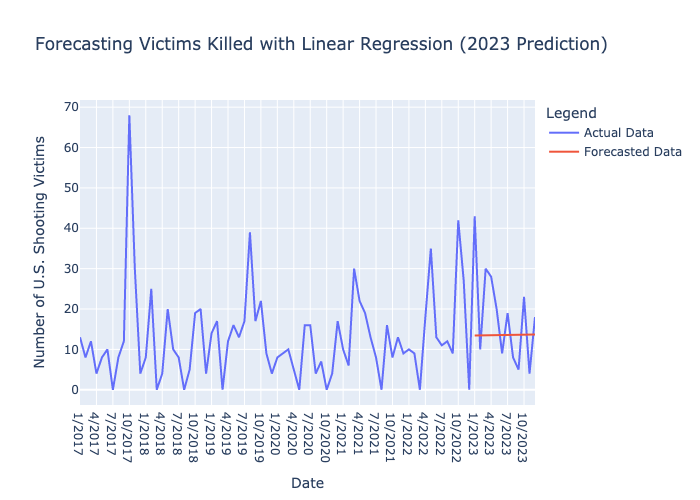

In [68]:
fig = px.line(victims_killed_linear, 
              x='level_0', 
              y='num_victims_killed', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_killed': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Killed with Linear Regression (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

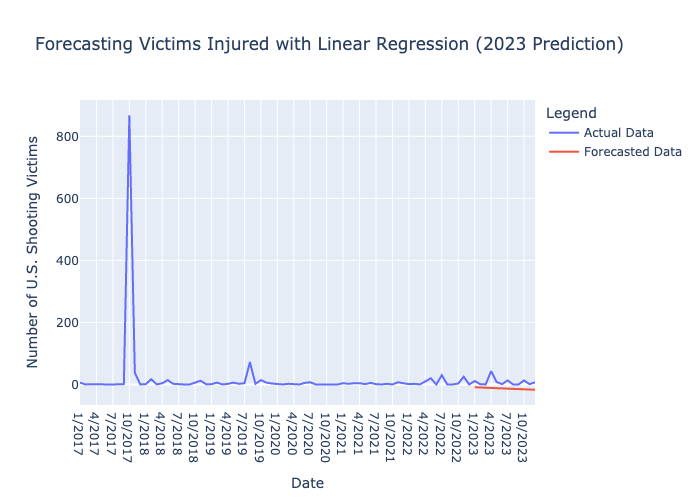

In [69]:
fig = px.line(victims_injured_linear, 
              x='level_0', 
              y='num_victims_injured', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_injured': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Injured with Linear Regression (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Using Polynomial Regression

In [70]:
y = victims_sum['num_victims_killed']

poly_features = PolynomialFeatures(2)
X_poly = poly_features.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

new_poly = poly_features.transform(np.arange(72, 84).reshape(-1, 1))
y_pred_poly_killed = poly_model.predict(new_poly)
y_pred_poly_killed

array([15.88212609, 16.10106989, 16.32538009, 16.55505668, 16.79009966,
       17.03050904, 17.27628482, 17.527427  , 17.78393556, 18.04581053,
       18.31305189, 18.58565964])

In [71]:
y = victims_sum['num_victims_injured']

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

new_poly = poly_features.transform(np.arange(72, 84).reshape(-1, 1))
y_pred_poly_injured = poly_model.predict(new_poly)
y_pred_poly_injured

array([10.58685446, 11.49032092, 12.43766089, 13.42887437, 14.46396136,
       15.54292185, 16.66575586, 17.83246337, 19.04304439, 20.29749893,
       21.59582697, 22.93802852])

In [72]:
forecast_killed = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_killed': y_pred_poly_killed, 
                                'Legend': ['Forecasted Data'] * 12})

forecast_injured = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                             '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                 'num_victims_injured': y_pred_poly_injured, 
                                 'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [73]:
victims_killed_polynomial = pd.concat([actual_killed, forecast_killed])
#victims_killed_polynomial.to_csv('victims_killed_polynomial.csv')

victims_injured_polynomial = pd.concat([actual_injured, forecast_injured])
#victims_injured_polynomial.to_csv('victims_injured_polynomial.csv')

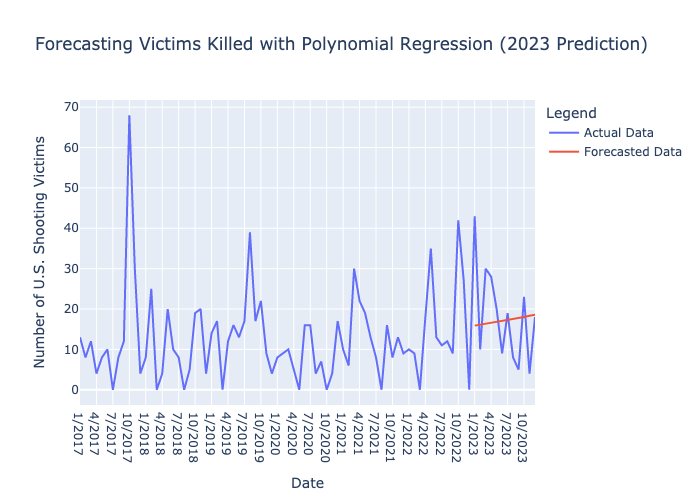

In [74]:
fig = px.line(victims_killed_polynomial, 
              x='level_0', 
              y='num_victims_killed', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_killed': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Killed with Polynomial Regression (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

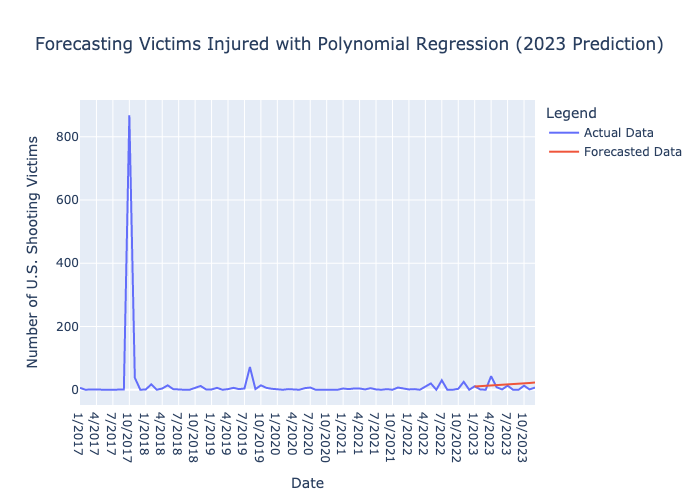

In [75]:
fig = px.line(victims_injured_polynomial, 
              x='level_0', 
              y='num_victims_injured', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_injured': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Injured with Polynomial Regression (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Forecasting with ARIMA (2023 Prediction)
# Using Manual ARIMA

In [76]:
model_killed = ARIMA(victims_sum['num_victims_killed'], order=(2,0,1))
model_fit_killed = model_killed.fit()
model_fit_killed.predict(72, 83)

72     7.713668
73    14.959363
74    13.645612
75    12.314127
76    12.536709
77    12.781159
78    12.743675
79    12.698836
80    12.705105
81    12.713322
82    12.712282
83    12.710778
Name: predicted_mean, dtype: float64

In [77]:
model_injured = ARIMA(victims_sum['num_victims_injured'], order=(0,0,0))
model_fit_injured = model_injured.fit()
model_fit_injured.predict(72, 83)

72    17.111107
73    17.111107
74    17.111107
75    17.111107
76    17.111107
77    17.111107
78    17.111107
79    17.111107
80    17.111107
81    17.111107
82    17.111107
83    17.111107
Name: predicted_mean, dtype: float64

In [78]:
forecast_killed = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_killed': model_fit_killed.predict(72, 83).values, 
                                'Legend': ['Forecasted Data'] * 12})

forecast_injured = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_injured': model_fit_injured.predict(72, 83).values, 
                                'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [79]:
victims_killed_arima = pd.concat([actual_killed, forecast_killed])
#victims_killed_arima.to_csv('victims_killed_arima.csv')

victims_injured_arima = pd.concat([actual_injured, forecast_injured])
#victims_injured_arima.to_csv('victims_injured_arima.csv')

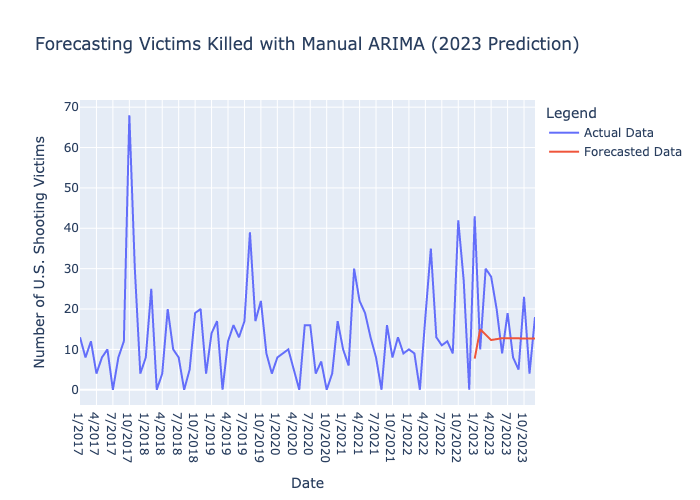

In [80]:
fig = px.line(victims_killed_arima, 
              x='level_0', 
              y='num_victims_killed', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_killed': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Killed with Manual ARIMA (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

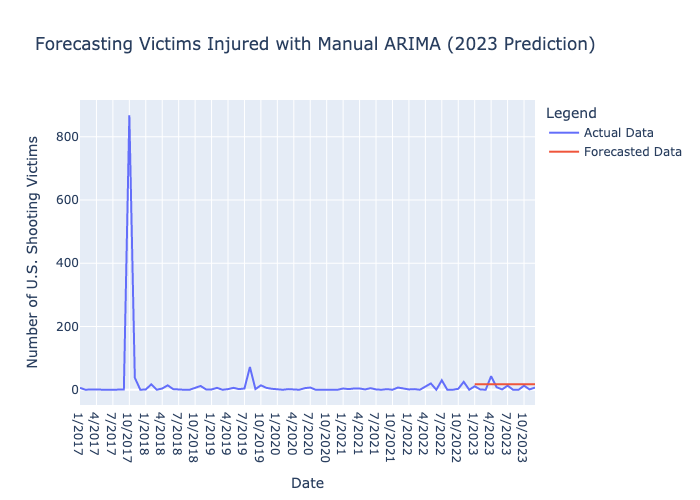

In [81]:
fig = px.line(victims_injured_arima, 
              x='level_0', 
              y='num_victims_injured', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_injured': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Injured with Manual ARIMA (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Using Auto ARIMA

In [82]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(victims_sum['num_victims_killed'])

(0.014970024289421832, False)

In [83]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(victims_sum['num_victims_injured'])

(0.01, False)

In [84]:
auto_model_killed = pm.auto_arima(victims_sum['num_victims_killed'], seasonal=False, stationary=False)
auto_model_killed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -272.739
Date:                Mon, 30 Sep 2024   AIC                            553.478
Time:                        12:52:51   BIC                            562.585
Sample:                             0   HQIC                           557.103
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.4393      3.683      3.378      0.001       5.221      19.657
ar.L1          0.2505      0.220      1.137      0.255      -0.181       0.682
ar.L2         -0.2310      0.185     -1.249      0.212      -0.593       0.132
sigma2       113.9882     12.093      9.426      0.000      90.286     137.690
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               269.75
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             2.27
Prob(H) (two-sided):                  0.19   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
auto_model_injured = pm.auto_arima(victims_sum['num_victims_injured'], seasonal=False, stationary=False)
auto_model_injured.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                        SARIMAX   Log Likelihood                -434.835
Date:                Mon, 30 Sep 2024   AIC                            873.670
Time:                        12:52:51   BIC                            878.224
Sample:                             0   HQIC                           875.483
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.1111    117.230      0.146      0.884    -212.656     246.878
sigma2      1.031e+04   2897.832      3.558      0.000    4630.452     1.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             13669.34
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                             8.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
auto_model_killed.predict(12)

72     6.203439
73    13.993275
74    14.511943
75    12.842755
76    12.304824
77    12.555580
78    12.742635
79    12.731579
80    12.685608
81    12.676645
82    12.685017
83    12.689185
dtype: float64

In [87]:
auto_model_injured.predict(12)

72    17.111111
73    17.111111
74    17.111111
75    17.111111
76    17.111111
77    17.111111
78    17.111111
79    17.111111
80    17.111111
81    17.111111
82    17.111111
83    17.111111
dtype: float64

In [88]:
forecast_killed = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_killed': auto_model_killed.predict(12).values, 
                                'Legend': ['Forecasted Data'] * 12})

forecast_injured = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_injured': auto_model_injured.predict(12).values, 
                                'Legend': ['Forecasted Data'] * 12})

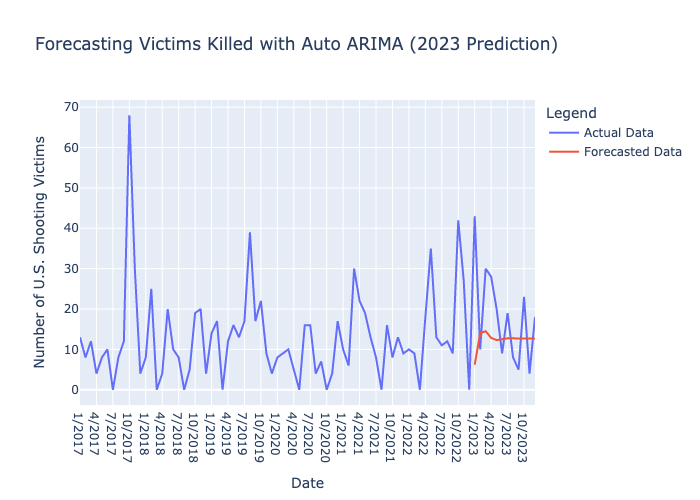

In [89]:
fig = px.line(pd.concat([actual_killed, forecast_killed]), 
              x='level_0', 
              y='num_victims_killed', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_killed': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Killed with Auto ARIMA (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

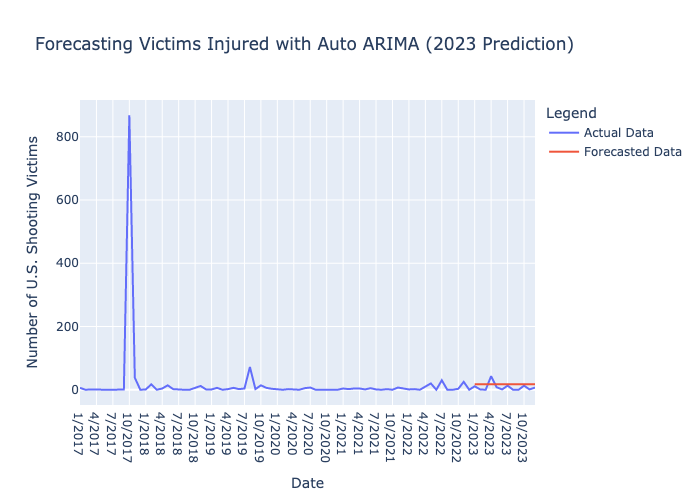

In [90]:
fig = px.line(pd.concat([actual_injured, forecast_injured]), 
              x='level_0', 
              y='num_victims_injured', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_injured': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Injured with Auto ARIMA (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Forecasting with Exponential Smoothing (2023 Prediction)
# Using Simple Exponential Smoothing

In [91]:
ses_fit_killed = SimpleExpSmoothing(victims_sum['num_victims_killed'], initialization_method='estimated').fit()
ses_fit_killed.predict(72, 83)

72    12.722221
73    12.722221
74    12.722221
75    12.722221
76    12.722221
77    12.722221
78    12.722221
79    12.722221
80    12.722221
81    12.722221
82    12.722221
83    12.722221
dtype: float64

In [92]:
ses_fit_injured = SimpleExpSmoothing(victims_sum['num_victims_injured'], initialization_method='estimated').fit()
ses_fit_injured.predict(72, 83)

72    7.909092
73    7.909092
74    7.909092
75    7.909092
76    7.909092
77    7.909092
78    7.909092
79    7.909092
80    7.909092
81    7.909092
82    7.909092
83    7.909092
dtype: float64

In [93]:
forecast_killed = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_killed': ses_fit_killed.predict(72, 83).values, 
                                'Legend': ['Forecasted Data'] * 12})

forecast_injured = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                             '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                 'num_victims_injured': ses_fit_injured.predict(72, 83).values, 
                                 'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [94]:
victims_killed_ses = pd.concat([actual_killed, forecast_killed])
#victims_killed_ses.to_csv('victims_killed_ses.csv')

victims_injured_ses = pd.concat([actual_injured, forecast_injured])
#victims_injured_ses.to_csv('victims_injured_ses.csv')

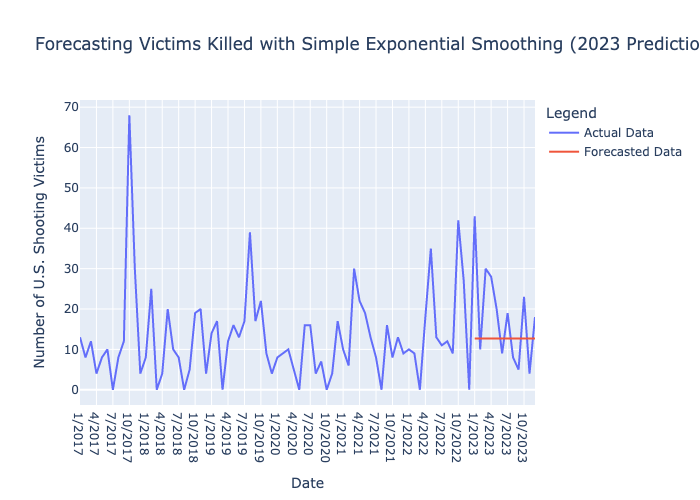

In [95]:
fig = px.line(victims_killed_ses, 
              x='level_0', 
              y='num_victims_killed', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_killed': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Killed with Simple Exponential Smoothing (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

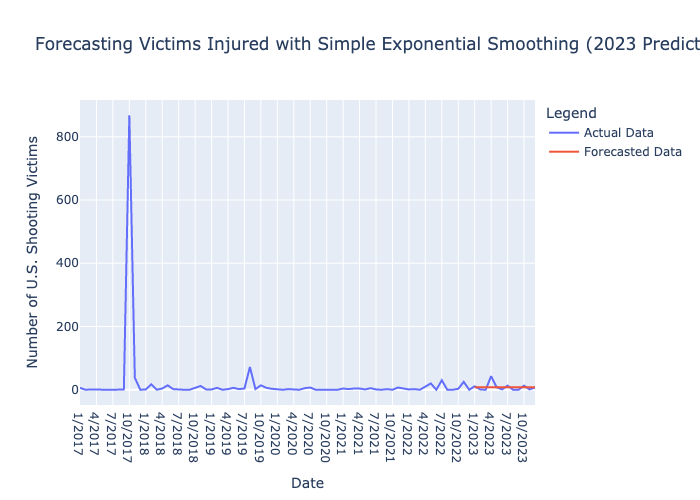

In [96]:
fig = px.line(victims_injured_ses, 
              x='level_0', 
              y='num_victims_injured', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_injured': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Injured with Simple Exponential Smoothing (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Using Holt's Method

In [97]:
holts_fit_killed = Holt(victims_sum['num_victims_killed'], initialization_method='estimated').fit()
holts_fit_killed.predict(72, 83)

72    13.466303
73    13.486689
74    13.507075
75    13.527461
76    13.547848
77    13.568234
78    13.588620
79    13.609006
80    13.629392
81    13.649779
82    13.670165
83    13.690551
dtype: float64

In [98]:
holts_fit_injured = Holt(victims_sum['num_victims_injured'], initialization_method='estimated').fit()
holts_fit_injured.predict(72, 83)

72    10.206041
73    10.592286
74    10.978531
75    11.364776
76    11.751021
77    12.137266
78    12.523511
79    12.909756
80    13.296002
81    13.682247
82    14.068492
83    14.454737
dtype: float64

In [99]:
forecast_killed = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                            '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                'num_victims_killed': holts_fit_killed.predict(72, 83).values, 
                                'Legend': ['Forecasted Data'] * 12})

forecast_injured = pd.DataFrame({'level_0': ['1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023', 
                                             '7/2023', '8/2023', '9/2023', '10/2023', '11/2023', '12/2023'], 
                                 'num_victims_injured': holts_fit_injured.predict(72, 83).values, 
                                 'Legend': ['Forecasted Data'] * 12})

## Writing to csv

In [100]:
victims_killed_holts = pd.concat([actual_killed, forecast_killed])
#victims_killed_holts.to_csv('victims_killed_holts.csv')

victims_injured_holts = pd.concat([actual_injured, forecast_injured])
#victims_injured_holts.to_csv('victims_injured_holts.csv')

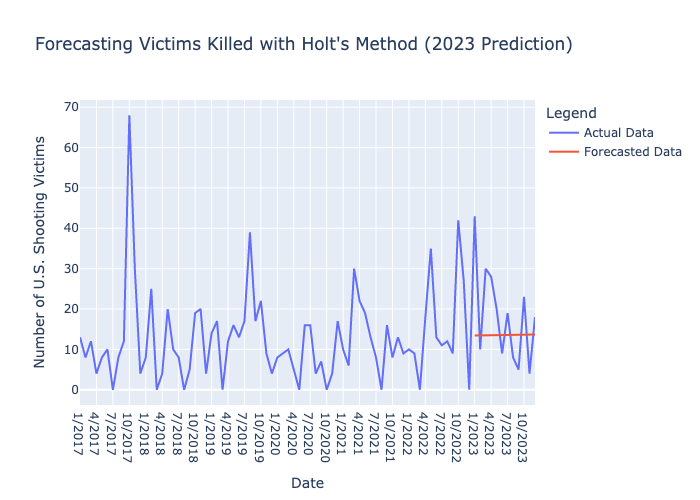

In [101]:
fig = px.line(victims_killed_holts, 
              x='level_0', 
              y='num_victims_killed', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_killed': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Killed with Holt\'s Method (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

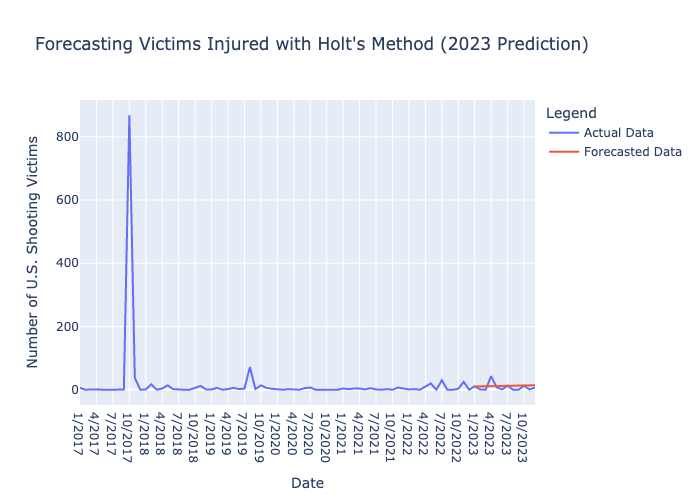

In [102]:
fig = px.line(victims_injured_holts, 
              x='level_0', 
              y='num_victims_injured', 
              color='Legend', 
              labels={'level_0': 'Date', 
                      'num_victims_injured': 'Number of U.S. Shooting Victims'}, 
              title='Forecasting Victims Injured with Holt\'s Method (2023 Prediction)')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# RMSE
# Victims Killed

In [103]:
print('Linear Regression: ', mean_squared_error(actual_2023['num_victims_killed'], y_pred_killed))
print('Polynomial Regression: ', mean_squared_error(actual_2023['num_victims_killed'], y_pred_poly_killed))

print('Manual ARIMA: ', mean_squared_error(actual_2023['num_victims_killed'], model_fit_killed.predict(72, 83)))
print('Auto ARIMA: ', mean_squared_error(actual_2023['num_victims_killed'], auto_model_killed.predict(12)))

print('SES: ', mean_squared_error(actual_2023['num_victims_killed'], ses_fit_killed.predict(72, 83)))
print('Holt\'s Method: ', mean_squared_error(actual_2023['num_victims_killed'], holts_fit_killed.predict(72, 83)))

Linear Regression:  146.92342921290256
Polynomial Regression:  137.69159541719114
Manual ARIMA:  181.95964871162712
Auto ARIMA:  186.852498446371
SES:  154.48458044368843
Holt's Method:  146.9238937772226


# Victims Injured

In [104]:
print('Linear Regression: ', mean_squared_error(actual_2023['num_victims_injured'], y_pred_injured))
print('Polynomial Regression: ', mean_squared_error(actual_2023['num_victims_injured'], y_pred_poly_injured))

print('Manual ARIMA: ', mean_squared_error(actual_2023['num_victims_injured'], model_fit_injured.predict(72, 83)))
print('Auto ARIMA: ', mean_squared_error(actual_2023['num_victims_injured'], auto_model_injured.predict(12)))

print('SES: ', mean_squared_error(actual_2023['num_victims_injured'], ses_fit_injured.predict(72, 83)))
print('Holt\'s Method: ', mean_squared_error(actual_2023['num_victims_injured'], holts_fit_injured.predict(72, 83)))

Linear Regression:  583.9212620107526
Polynomial Regression:  234.84818016740726
Manual ARIMA:  215.30857121212213
Auto ARIMA:  215.30864197530855
SES:  135.3719003387854
Holt's Method:  160.21360491674605


# Number of U.S. Shooting Victims by Year

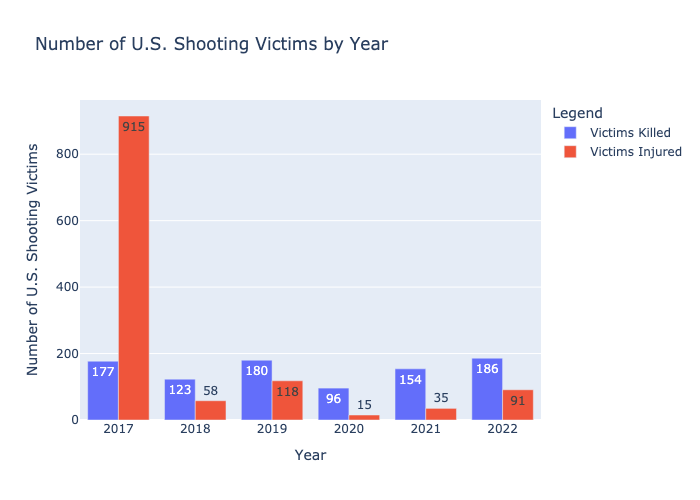

In [105]:
victims_year_sum = shooting_incidents.groupby(by='year').sum()

fig = px.bar(victims_year_sum, 
             y=['num_victims_killed', 'num_victims_injured'], 
             barmode='group', 
             labels={'year': 'Year', 
                     'value': 'Number of U.S. Shooting Victims', 
                     'variable': 'Legend'}, 
             title='Number of U.S. Shooting Victims by Year', 
             text_auto=True)

newnames = {'num_victims_killed': 'Victims Killed', 'num_victims_injured': 'Victims Injured'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of U.S. Shooting Incidents by State (2017-2022)

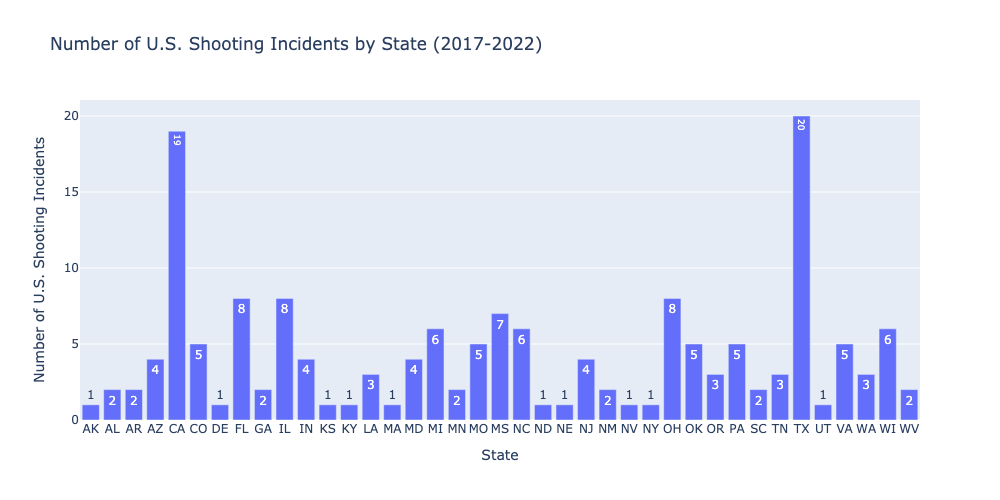

In [106]:
incidents_state_count = shooting_incidents.groupby(by='state').count()

fig = px.bar(incidents_state_count['incident_id'], 
             labels={'state': 'State', 
                     'value': 'Number of U.S. Shooting Incidents'}, 
             title='Number of U.S. Shooting Incidents by State (2017-2022)', 
             text_auto=True, 
             width=1000)

fig.update_layout(showlegend=False, 
                  xaxis=dict(tickmode='linear'))

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of U.S. Shooting Incidents by Location Type (2017-2022)

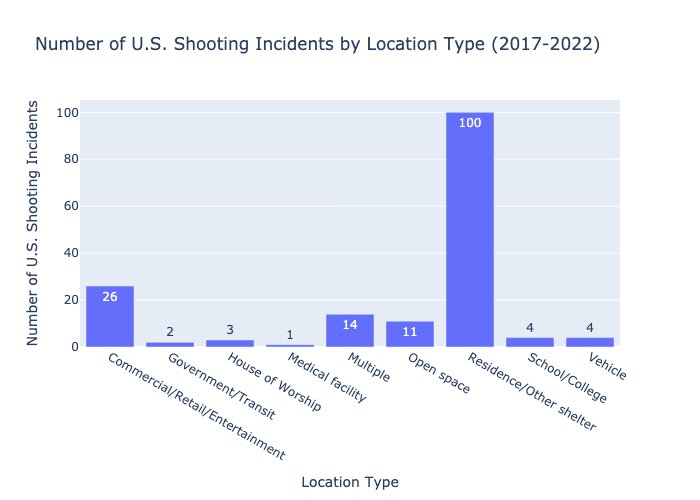

In [107]:
incidents_location_count = shooting_incidents.groupby(by='location_type').count()

fig = px.bar(incidents_location_count['incident_id'], 
             labels={'location_type': 'Location Type', 
                     'value': 'Number of U.S. Shooting Incidents'}, 
             title='Number of U.S. Shooting Incidents by Location Type (2017-2022)', 
             text_auto=True) 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of U.S. Shooting Victims by State (2017-2022)

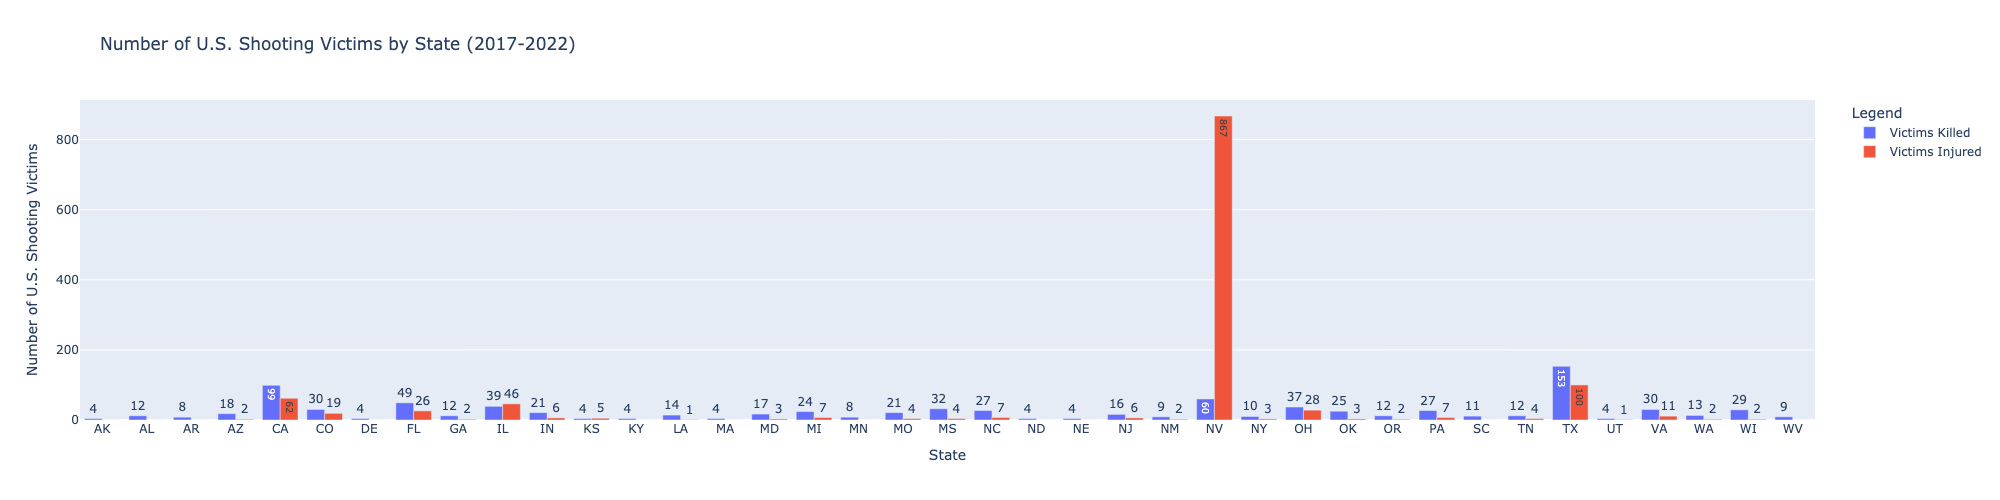

In [108]:
victims_year_sum = shooting_incidents.groupby(by='state').sum()

fig = px.bar(victims_year_sum, 
             y=['num_victims_killed', 'num_victims_injured'], 
             barmode='group', 
             labels={'state': 'State', 
                     'value': 'Number of U.S. Shooting Victims', 
                     'variable': 'Legend'}, 
             title='Number of U.S. Shooting Victims by State (2017-2022)', 
             text_auto=True,
             width=2000)

newnames = {'num_victims_killed': 'Victims Killed', 'num_victims_injured': 'Victims Injured'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of U.S. Shooting Victims by Location Type (2017-2022)

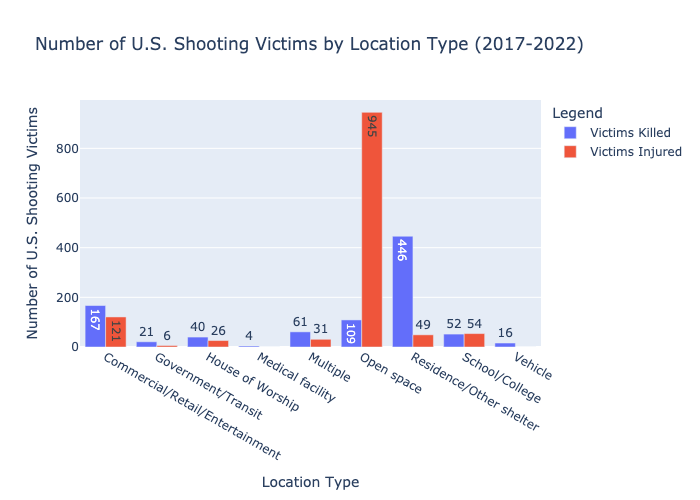

In [109]:
victims_year_sum = shooting_incidents.groupby(by='location_type').sum()

fig = px.bar(victims_year_sum, 
             y=['num_victims_killed', 'num_victims_injured'], 
             barmode='group', 
             labels={'location_type': 'Location Type', 
                     'value': 'Number of U.S. Shooting Victims', 
                     'variable': 'Legend'}, 
             title='Number of U.S. Shooting Victims by Location Type (2017-2022)', 
             text_auto=True)

newnames = {'num_victims_killed': 'Victims Killed', 'num_victims_injured': 'Victims Injured'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. Shooting Offenders

In [110]:
shooting_offenders.head()

Unnamed: 0  incident_id  offender_id  firstname middlename lastname suffix  \
0         385          318          390      Keith        NaN  Kroeker    NaN   
1         386          320          392  Briddell         NaN   Barber    NaN   
2         387          321          393      Karon    Deshawn    McVay    NaN   
3         389          323          395    Armande    Stephen     Tart    NaN   
4         390          324          396     Nengmy        NaN     Vang    NaN   

    age                    race   sex  suicide deathcause  \
0  42.0                   White  Male     True   Shooting   
1  27.0                   Black  Male    False        NaN   
2  44.0                   Black  Male    False        NaN   
3  20.0                   Black  Male    False        NaN   
4  45.0  Asian/Pacific Islander  Male     True   Shooting   

               outcome criminal_justice_process                 sentence_type  \
0              Suicide           Not applicable                           NaN   
1  Life without parole                     Plea  Life sentence without parole   
2  Life without parole                    Trial  Life sentence without parole   
3        Life sentence                    Trial                 Life sentence   
4               Killed           Not applicable                           NaN   

               sentence_details  
0                           NaN  
1                           NaN  
2                           NaN  
3  4 consecutive life sentences  
4                           NaN

# Number of U.S. Shooting Offenders by Race & Sex (2017-2022)

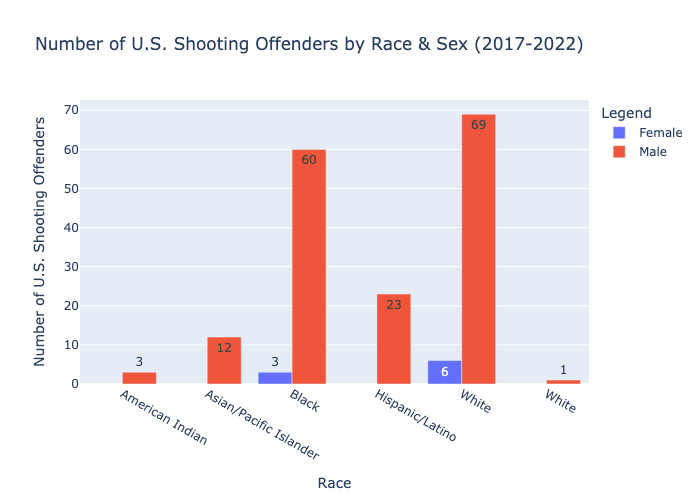

In [111]:
offenders_race_sex = shooting_offenders.groupby(['race', 'sex']).count().unstack('sex')

fig = px.bar(offenders_race_sex['incident_id'], 
             barmode='group', 
             labels={'race': 'Race',
                     'value': 'Number of U.S. Shooting Offenders', 
                     'sex': 'Legend'}, 
             title='Number of U.S. Shooting Offenders by Race & Sex (2017-2022)', 
             text_auto=True)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of U.S. Shooting Offenders by Age (2017-2022)

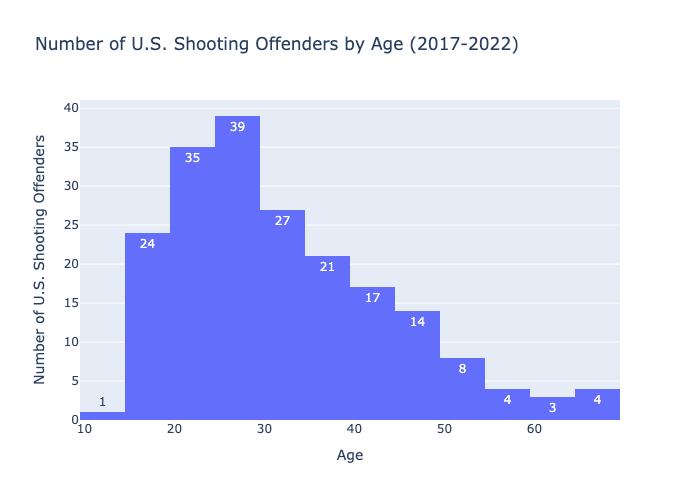

In [112]:
fig = px.histogram(shooting_offenders['age'], 
                   labels={'value': 'Age'}, 
                   title='Number of U.S. Shooting Offenders by Age (2017-2022)', 
                   text_auto=True)

fig.update_layout(showlegend=False, yaxis_title='Number of U.S. Shooting Offenders') 

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. Shooting Victims

In [113]:
shooting_victims.head()

Unnamed: 0  incident_id  victim_id   age   race     sex      vorelationship
0        1629          318       1630  39.0  White  Female              Spouse
1        1630          318       1631  10.0  White    Male  Child or stepchild
2        1631          318       1632  10.0  White    Male  Child or stepchild
3        1632          318       1633   7.0  White  Female  Child or stepchild
4        1633          319       1634  37.0  White  Female        Undetermined

# Number of U.S. Shooting Victims by Race & Sex (2017-2022)

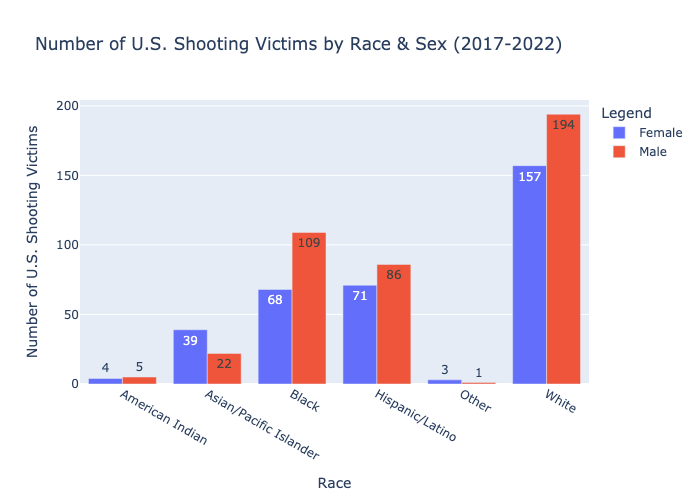

In [114]:
victims_race_sex = shooting_victims.groupby(['race', 'sex']).count().unstack('sex')

fig = px.bar(victims_race_sex['incident_id'], 
             barmode='group', 
             labels={'race': 'Race',
                     'value': 'Number of U.S. Shooting Victims', 
                     'sex': 'Legend'}, 
             title='Number of U.S. Shooting Victims by Race & Sex (2017-2022)', 
             text_auto=True)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of U.S. Shooting Victims by Age (2017-2022)

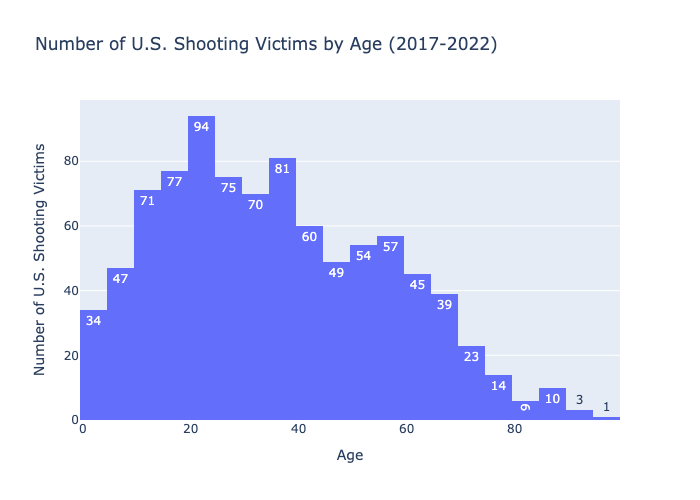

In [115]:
fig = px.histogram(shooting_victims['age'], 
                   labels={'value': 'Age'}, 
                   title='Number of U.S. Shooting Victims by Age (2017-2022)', 
                   text_auto=True)

fig.update_layout(showlegend=False, yaxis_title='Number of U.S. Shooting Victims') 

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. Shooting Weapons

In [116]:
shooting_weapons.head()

Unnamed: 0  incident_id  weapon_id weapon_type gun_class  \
0         510          318        519         gun        LG   
1         513          319        522         gun        UG   
2         514          320        523         gun        UG   
3         515          321        524         gun        HG   
4         518          323        527         gun        HG   

                gun_type  
0                shotgun  
1                    NaN  
2                    NaN  
3  semiautomatic handgun  
4  semiautomatic handgun

# Number of U.S. Shooting Weapons by Gun Type (2017-2022)

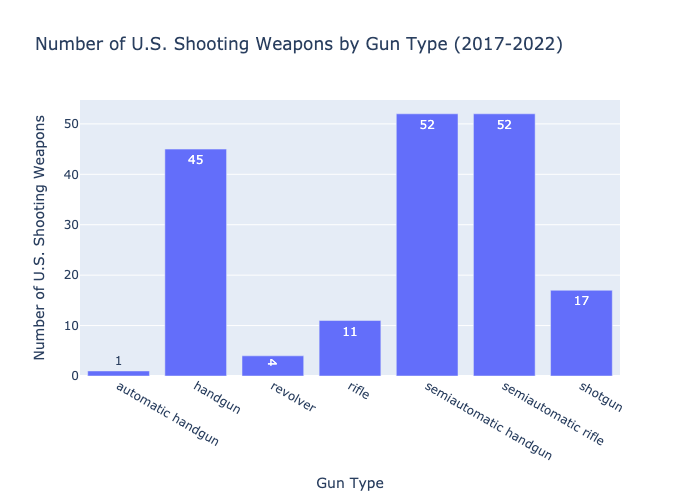

In [117]:
gun_type_count = shooting_weapons.groupby(by='gun_type').count()

fig = px.bar(gun_type_count['incident_id'], 
             labels={'gun_type': 'Gun Type', 
                     'value': 'Number of U.S. Shooting Weapons'}, 
             title='Number of U.S. Shooting Weapons by Gun Type (2017-2022)', 
             text_auto=True)

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of Victims of Firearm Homicides

In [118]:
countries_count.head()

Unnamed: 0 Iso3_code              Country    Region  \
0       27946       ARG            Argentina  Americas   
1       27947       ARM              Armenia      Asia   
2       27948       ATG  Antigua and Barbuda  Americas   
3       27949       AZE           Azerbaijan      Asia   
4       27950       BGR             Bulgaria    Europe   

                         Subregion                        Indicator  \
0  Latin America and the Caribbean  Victims of intentional homicide   
1                     Western Asia  Victims of intentional homicide   
2  Latin America and the Caribbean  Victims of intentional homicide   
3                     Western Asia  Victims of intentional homicide   
4                   Eastern Europe  Victims of intentional homicide   

       Dimension                Category    Sex    Age  Year  \
0  by mechanisms  Firearms or explosives  Total  Total  2017   
1  by mechanisms  Firearms or explosives  Total  Total  2017   
2  by mechanisms  Firearms or explosives  Total  Total  2017   
3  by mechanisms  Firearms or explosives  Total  Total  2017   
4  by mechanisms  Firearms or explosives  Total  Total  2017   

  Unit of measurement  VALUE Source  
0              Counts   1245    CTS  
1              Counts     18    CTS  
2              Counts     10    CTS  
3              Counts     18    CTS  
4              Counts     17    CTS

# 25 Countries with the Most Victims of Firearm Homicides (2017-2022)

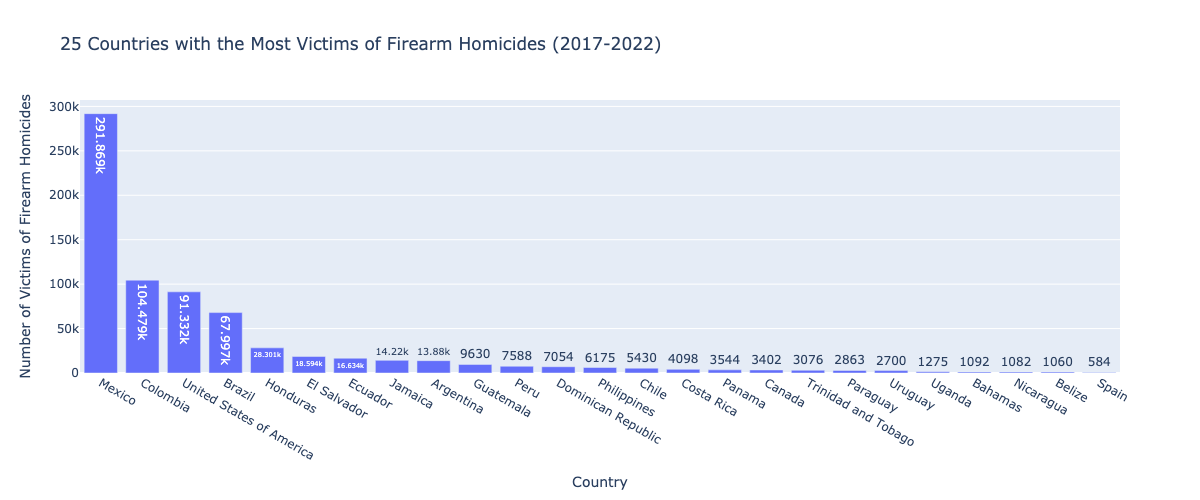

In [119]:
country_sum = countries_count.groupby(by='Country').sum()
most_homicides_country = country_sum.sort_values(by=['VALUE'], ascending=False).head(25)

fig = px.bar(most_homicides_country,  
             y='VALUE', 
             labels={'VALUE': 'Number of Victims of Firearm Homicides'}, 
             title='25 Countries with the Most Victims of Firearm Homicides (2017-2022)', 
             text_auto=True, 
             width=1200)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

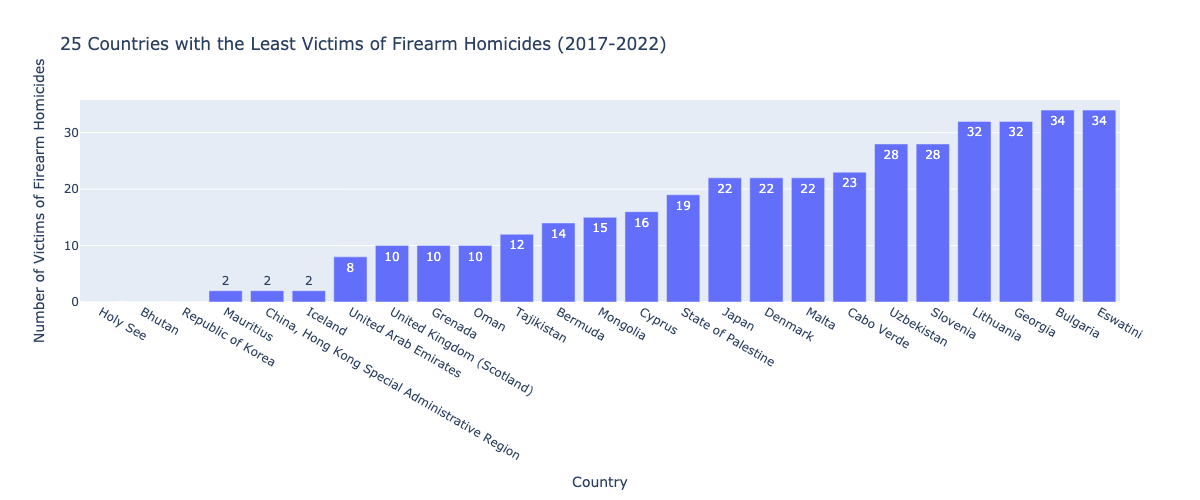

In [120]:
least_homicides_country = country_sum.sort_values(by=['VALUE']).head(25)

fig = px.bar(least_homicides_country,  
             y='VALUE', 
             labels={'VALUE': 'Number of Victims of Firearm Homicides'}, 
             title='25 Countries with the Least Victims of Firearm Homicides (2017-2022)', 
             text_auto=True, 
             width=1200)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of Victims of Firearm Homicides by Region (2017-2022)

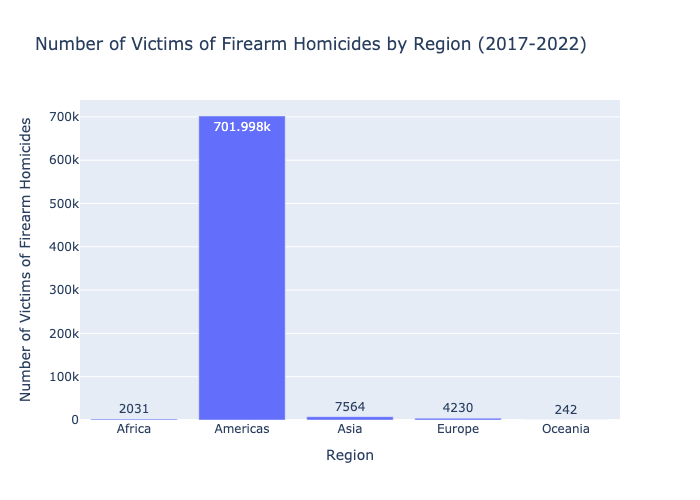

In [121]:
region_sum = countries_count.groupby(by='Region').sum()

fig = px.bar(region_sum['VALUE'], 
             labels={'value': 'Number of Victims of Firearm Homicides'}, 
             title='Number of Victims of Firearm Homicides by Region (2017-2022)', 
             text_auto=True)

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Number of Victims of Firearm Homicides by Subregion (2017-2022)

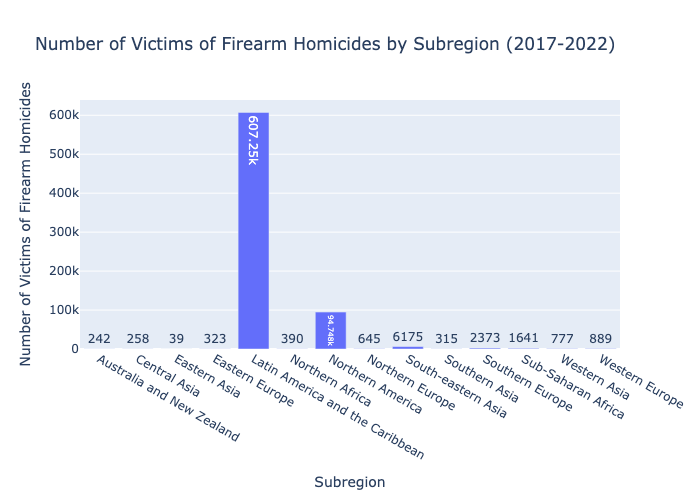

In [122]:
subregion_sum = countries_count.groupby(by='Subregion').sum()

fig = px.bar(subregion_sum['VALUE'], 
             labels={'value': 'Number of Victims of Firearm Homicides'}, 
             title='Number of Victims of Firearm Homicides by Subregion (2017-2022)', 
             text_auto=True)

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Rate of Victims of Firearm Homicides (per 100,000 Population)

In [123]:
countries_rate.head()

Unnamed: 0 Iso3_code              Country    Region  \
0       87388       ARG            Argentina  Americas   
1       87389       ARM              Armenia      Asia   
2       87390       ATG  Antigua and Barbuda  Americas   
3       87391       AZE           Azerbaijan      Asia   
4       87392       BGR             Bulgaria    Europe   

                         Subregion                        Indicator  \
0  Latin America and the Caribbean  Victims of intentional homicide   
1                     Western Asia  Victims of intentional homicide   
2  Latin America and the Caribbean  Victims of intentional homicide   
3                     Western Asia  Victims of intentional homicide   
4                   Eastern Europe  Victims of intentional homicide   

       Dimension                Category    Sex    Age  Year  \
0  by mechanisms  Firearms or explosives  Total  Total  2017   
1  by mechanisms  Firearms or explosives  Total  Total  2017   
2  by mechanisms  Firearms or explosives  Total  Total  2017   
3  by mechanisms  Firearms or explosives  Total  Total  2017   
4  by mechanisms  Firearms or explosives  Total  Total  2017   

           Unit of measurement      VALUE Source  
0  Rate per 100,000 population   2.826038    CTS  
1  Rate per 100,000 population   0.631153    CTS  
2  Rate per 100,000 population  10.974660    CTS  
3  Rate per 100,000 population   0.178721    CTS  
4  Rate per 100,000 population   0.236689    CTS

# 25 Countries with the Highest Yearly Rate of Victims of Firearm Homicides (2017-2022)

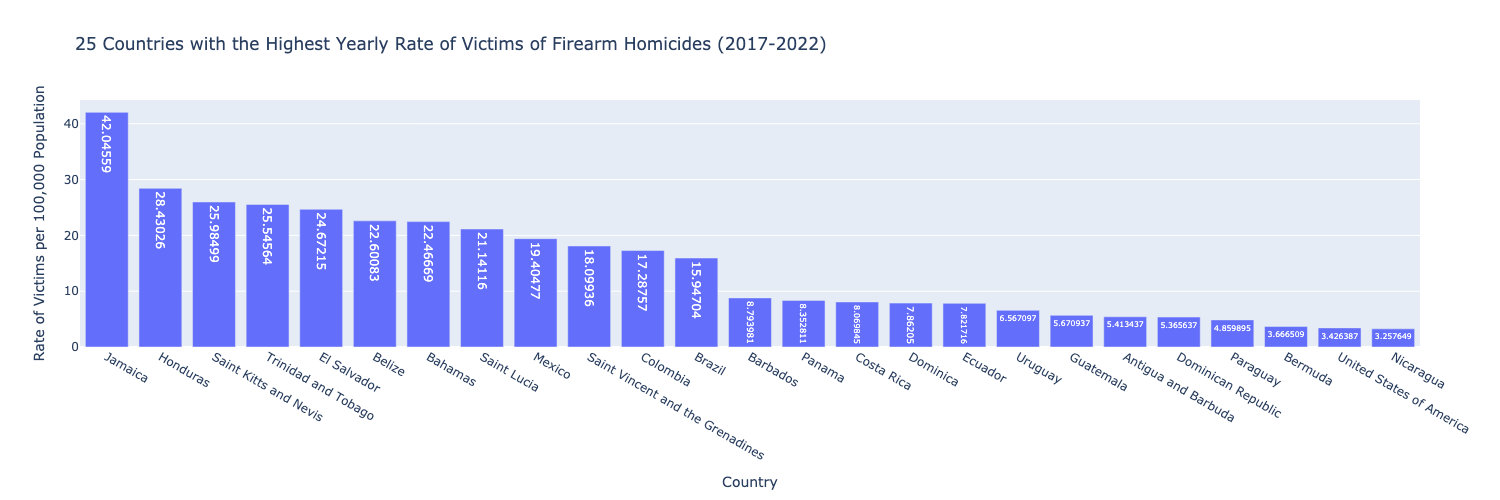

In [124]:
country_mean = countries_rate.groupby(by='Country').mean()
highest_country_rate = country_mean.sort_values(by=['VALUE'], ascending=False).head(25)

fig = px.bar(highest_country_rate, 
             y='VALUE', 
             labels={'VALUE': 'Rate of Victims per 100,000 Population'}, 
             title='25 Countries with the Highest Yearly Rate of Victims of Firearm Homicides (2017-2022)', 
             text_auto=True, width=1500)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# 25 Countries with the Lowest Yearly Rate of Victims of Firearm Homicides (2017-2022)

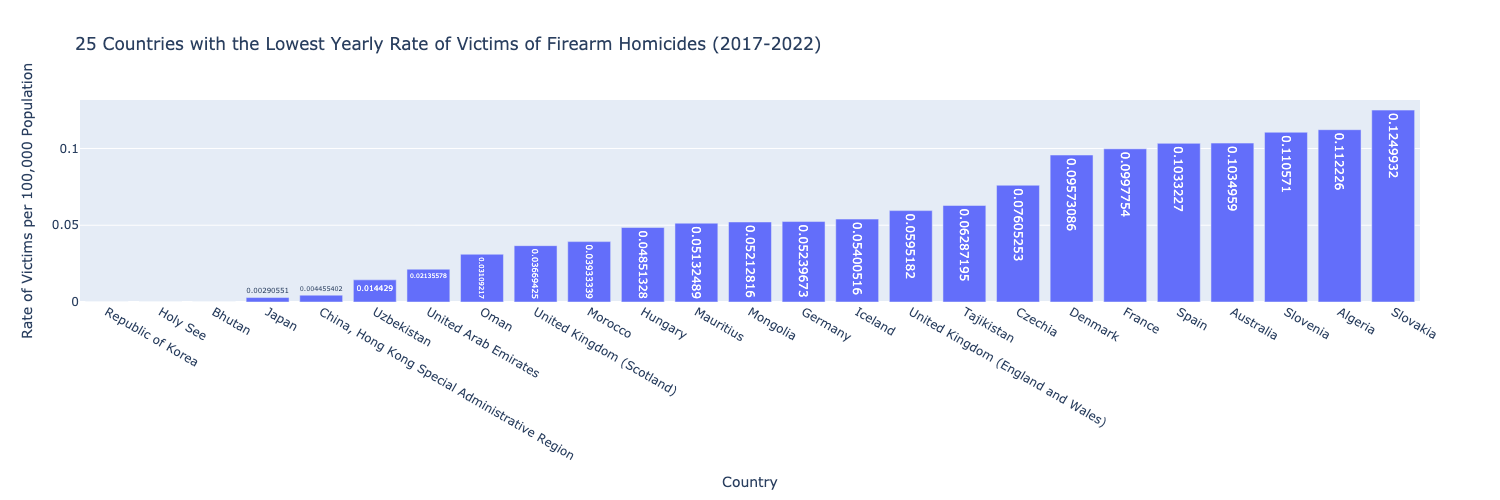

In [125]:
lowest_country_rate = country_mean.sort_values(by=['VALUE']).head(25)

fig = px.bar(lowest_country_rate, 
             y='VALUE', 
             labels={'VALUE': 'Rate of Victims per 100,000 Population'}, 
             title='25 Countries with the Lowest Yearly Rate of Victims of Firearm Homicides (2017-2022)', 
             text_auto=True, width=1500)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Yearly Rate of Victims of Firearm Homicides by Region (2017-2022)

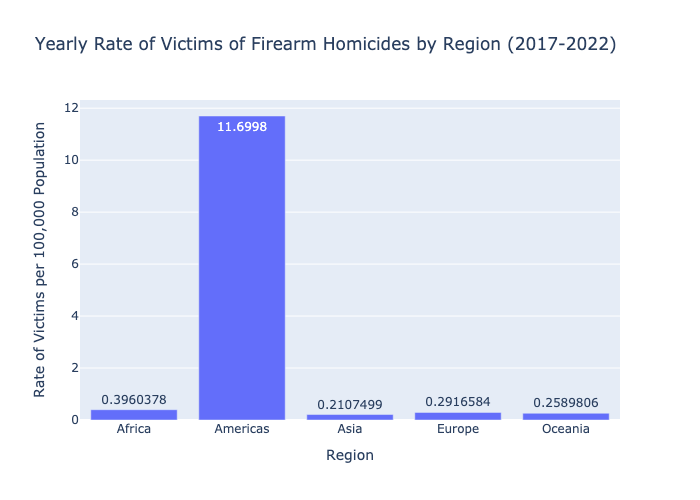

In [126]:
region_mean = countries_rate.groupby(by='Region').mean()

fig = px.bar(region_mean['VALUE'], 
             labels={'value': 'Rate of Victims per 100,000 Population'}, 
             title='Yearly Rate of Victims of Firearm Homicides by Region (2017-2022)', 
             text_auto=True) 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Yearly Rate of Victims of Firearm Homicides by Subregion (2017-2022)

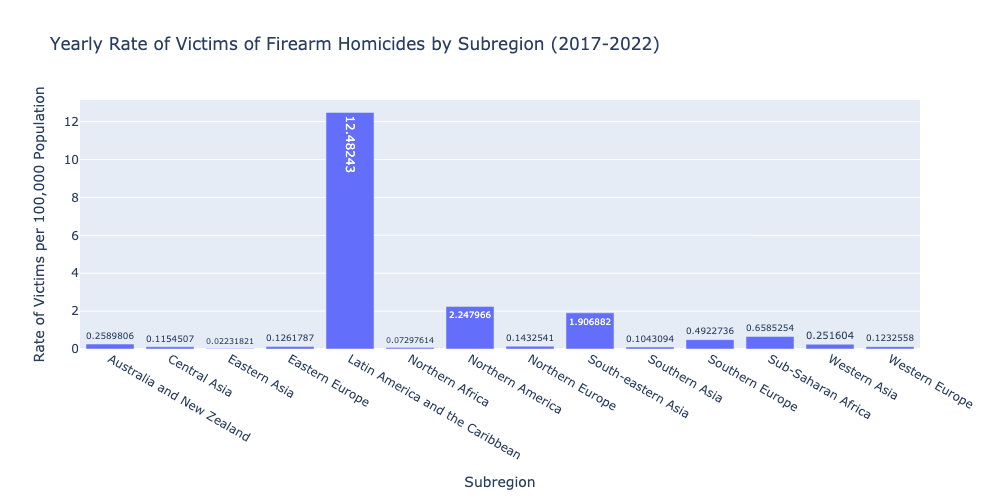

In [127]:
subregion_mean = countries_rate.groupby(by='Subregion').mean()

fig = px.bar(subregion_mean['VALUE'], 
             labels={'value': 'Rate of Victims per 100,000 Population'}, 
             title='Yearly Rate of Victims of Firearm Homicides by Subregion (2017-2022)', 
             text_auto=True, 
             width=1000)

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Categories

In [128]:
categories.head()

2017                                     \
0                                 ALABAMA ALASKA ARIZONA ARKANSAS CALIFORNIA   
CATEGORIES                                                                     
ABORTION                              6.0    0.0     0.0      0.0        0.0   
AGGRAVATED ASSAULT                   66.0   16.0   365.0     51.0      904.0   
ALTERING IDENTIFICATION ON WEAPON    15.0    0.0     3.0      1.0      119.0   
ARSON                                 0.0    0.0     0.0      0.0       15.0   
BRIBERY                               0.0    0.0     0.0      0.0        8.0   

                                                                 \
0                                 COLORADO CONNECTICUT DELAWARE   
CATEGORIES                                                        
ABORTION                               0.0         0.0      0.0   
AGGRAVATED ASSAULT                   173.0        19.0     53.0   
ALTERING IDENTIFICATION ON WEAPON      6.0         1.0      1.0   
ARSON                                  1.0         0.0      0.0   
BRIBERY                                0.0         0.0      0.0   

                                                                ...    2022  \
0                                 DISTRICT OF COLUMBIA FLORIDA  ...   TEXAS   
CATEGORIES                                                      ...           
ABORTION                                           0.0     0.0  ...     3.0   
AGGRAVATED ASSAULT                                57.0  1237.0  ...  3275.0   
ALTERING IDENTIFICATION ON WEAPON                  0.0     7.0  ...    13.0   
ARSON                                              0.0     4.0  ...     4.0   
BRIBERY                                            0.0     2.0  ...     1.0   

                                                                             \
0                                 US VIRGIN ISLANDS   UTAH VERMONT VIRGINIA   
CATEGORIES                                                                    
ABORTION                                        0.0    0.0     0.0      0.0   
AGGRAVATED ASSAULT                              0.0  152.0     8.0    285.0   
ALTERING IDENTIFICATION ON WEAPON               0.0    0.0     0.0      2.0   
ARSON                                           0.0    4.0     0.0      1.0   
BRIBERY                                         0.0    0.0     0.0      1.0   

                                                                              \
0                                 WASHINGTON WEST VIRGINIA WISCONSIN WYOMING   
CATEGORIES                                                                     
ABORTION                                 0.0           0.0       0.0     0.0   
AGGRAVATED ASSAULT                     459.0          44.0      49.0    11.0   
ALTERING IDENTIFICATION ON WEAPON        3.0           0.0       0.0     0.0   
ARSON                                    1.0           0.0       0.0     0.0   
BRIBERY                                  1.0           0.0       0.0     0.0   

                                            
0                                    TOTAL  
CATEGORIES                                  
ABORTION                               5.0  
AGGRAVATED ASSAULT                 18554.0  
ALTERING IDENTIFICATION ON WEAPON    229.0  
ARSON                                199.0  
BRIBERY                               53.0  

[5 rows x 330 columns]

# U.S. Number of Crimes with Firearms (2017-2022)

In [129]:
us_categories = categories.groupby(axis=1, level=0).sum()
us_categories.head()

2017     2018     2019     2020  \
CATEGORIES                                                              
ABORTION                              30.0      4.0     10.0     16.0   
AGGRAVATED ASSAULT                 20800.0  22454.0  23950.0  32284.0   
ALTERING IDENTIFICATION ON WEAPON    524.0    466.0    500.0    514.0   
ARSON                                184.0    384.0    124.0    246.0   
BRIBERY                               98.0    134.0     56.0     74.0   

                                      2021     2022  
CATEGORIES                                           
ABORTION                              12.0     10.0  
AGGRAVATED ASSAULT                 35746.0  37108.0  
ALTERING IDENTIFICATION ON WEAPON    418.0    458.0  
ARSON                                254.0    398.0  
BRIBERY                               86.0    106.0

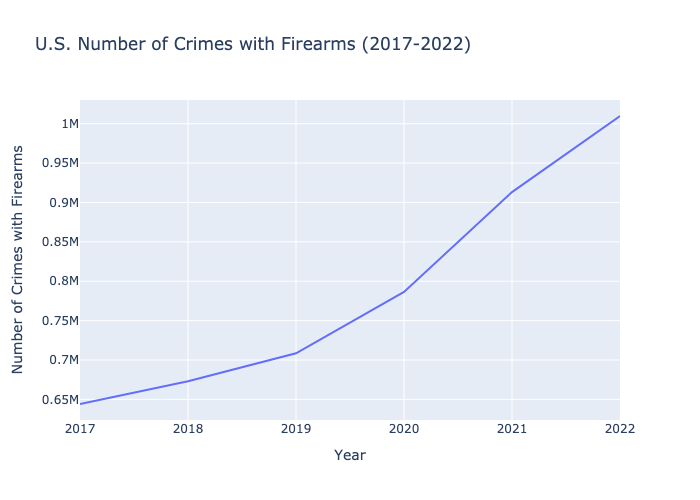

In [130]:
fig = px.line(us_categories.loc['TOTAL'], 
              labels={'value': 'Number of Crimes with Firearms', 
                      'index': 'Year'}, 
              title='U.S. Number of Crimes with Firearms (2017-2022)') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. 2022 Crime Category of Firearms

In [131]:
us_2022 = categories.loc[:, ['2022']]
us_2022 = pd.DataFrame(us_2022.sum(axis=1))
us_2022 = us_2022.rename(columns={0: '2022'})
us_2022 = us_2022.rename_axis(None)
us_2022 = us_2022.dropna()
us_2022 = us_2022[us_2022['2022'] != 0]
us_2022 = us_2022.drop(['TOTAL'])
us_2022.head()

2022
ABORTION                              10.0
AGGRAVATED ASSAULT                 37108.0
ALTERING IDENTIFICATION ON WEAPON    458.0
ARSON                                398.0
BRIBERY                              106.0

In [132]:
us_old_total = us_2022['2022'].sum()
us_2022 = us_2022[((us_2022['2022'] / us_2022['2022'].sum()) * 100) > 1.0]
us_new_total = us_2022['2022'].sum()
us_2022.loc['OTHER'] = us_old_total - us_new_total
us_2022.head()

2022
AGGRAVATED ASSAULT            37108.0
CARRYING CONCEALED WEAPON     39364.0
DANGEROUS DRUGS               65608.0
FAMILY OFFENSE                27568.0
FIREARM UNDER INVESTIGATION  201390.0

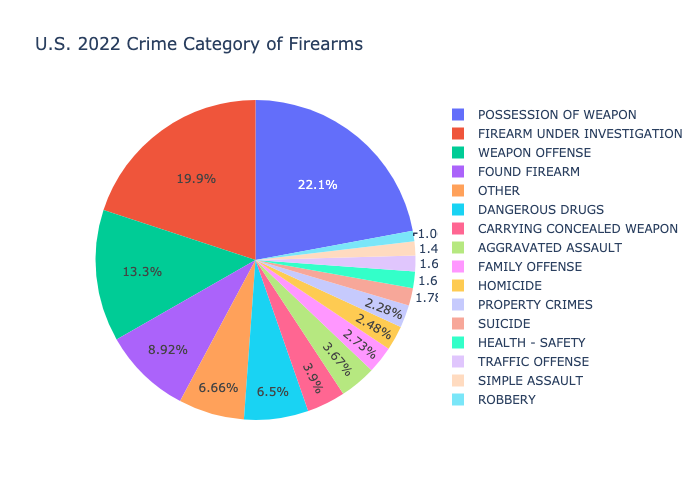

In [133]:
fig = px.pie(us_2022, 
             values='2022', 
             names=us_2022.index, 
             title='U.S. 2022 Crime Category of Firearms')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC Number of Crimes with Firearms (2017-2022)

In [134]:
nc_categories = categories.loc[:, (['2017', '2018', '2019', '2020', '2021', '2022'], ['NORTH CAROLINA'])]
nc_categories.columns = nc_categories.columns.droplevel(1)
nc_categories.head()

2017   2018   2019   2020   2021   2022
CATEGORIES                                                                 
ABORTION                             0.0    0.0    0.0    1.0    0.0    0.0
AGGRAVATED ASSAULT                 388.0  411.0  518.0  589.0  759.0  640.0
ALTERING IDENTIFICATION ON WEAPON   14.0    9.0   19.0    9.0   23.0   25.0
ARSON                                3.0    0.0    3.0    5.0    0.0    4.0
BRIBERY                              0.0    2.0    5.0    4.0    1.0    5.0

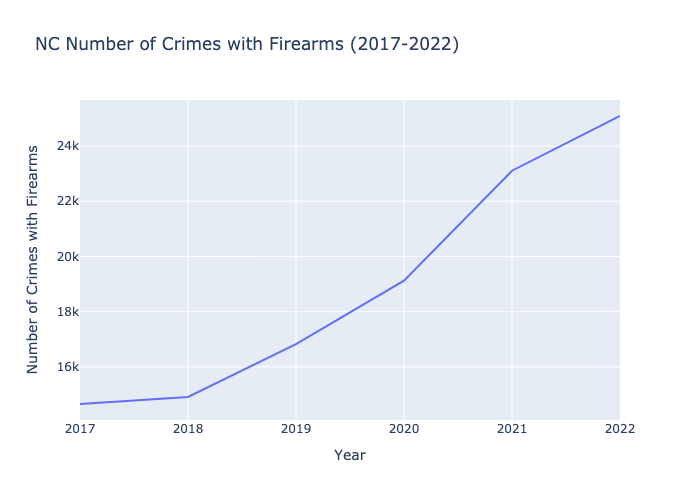

In [135]:
fig = px.line(nc_categories.loc['TOTAL'], 
              labels={'value': 'Number of Crimes with Firearms', 
                      'index': 'Year'}, 
              title='NC Number of Crimes with Firearms (2017-2022)') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC 2022 Crime Category of Firearms

In [136]:
nc_2022 = categories.loc[:, (['2022'], ['NORTH CAROLINA'])]
nc_2022.columns = nc_2022.columns.droplevel(1)
nc_2022 = nc_2022.rename_axis(None)
nc_2022 = nc_2022.dropna()
nc_2022 = nc_2022[nc_2022['2022'] != 0]
nc_2022 = nc_2022.drop(['TOTAL'])
nc_2022.head()

2022
AGGRAVATED ASSAULT                 640.0
ALTERING IDENTIFICATION ON WEAPON   25.0
ARSON                                4.0
BRIBERY                              5.0
BURGLARY                           124.0

In [137]:
nc_old_total = nc_2022['2022'].sum()
nc_2022 = nc_2022[((nc_2022['2022'] / nc_2022['2022'].sum()) * 100) > 1.0]
nc_new_total = nc_2022['2022'].sum()
nc_2022.loc['OTHER'] = nc_old_total - nc_new_total
nc_2022.head()

2022
AGGRAVATED ASSAULT            640.0
CARRYING CONCEALED WEAPON    2177.0
DANGEROUS DRUGS              1465.0
FAMILY OFFENSE               1015.0
FIREARM UNDER INVESTIGATION  3731.0

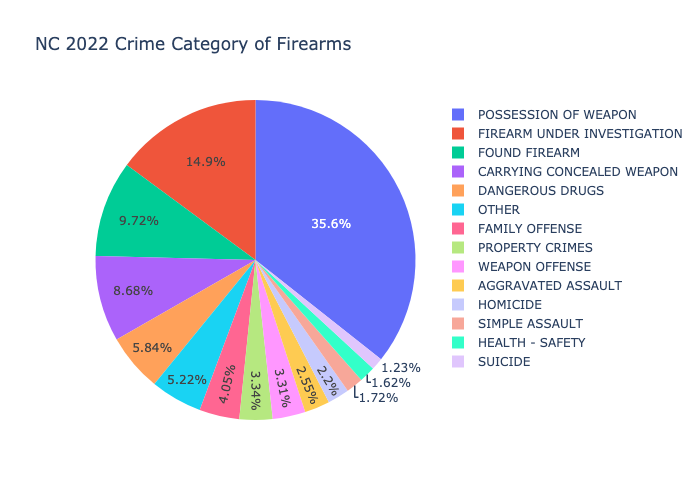

In [138]:
fig = px.pie(nc_2022, 
             values='2022', 
             names=nc_2022.index, 
             title='NC 2022 Crime Category of Firearms')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Ages of Possessors

In [139]:
ages.head()

2017                                                          \
           ALABAMA ALASKA ARIZONA ARKANSAS CALIFORNIA COLORADO CONNECTICUT   
AGES                                                                         
17 & Under      99     11     117       43        687      156          22   
18 to 21       511     60     544      139       2981      294          74   
22 to 24       442     77     536      100       2748      342          76   
25 to 30       691    170     936      205       5545      645         147   
31 to 40       882    194    1078      316       7011      900         180   

                                                  ...      2022        \
           DELAWARE DISTRICT OF COLUMBIA FLORIDA  ... TENNESSEE TEXAS   
AGES                                              ...                   
17 & Under       41                   60     617  ...       612  1618   
18 to 21        115                  271    1730  ...      1791  5227   
22 to 24        112                  203    1469  ...      1319  4329   
25 to 30        219                  279    2660  ...      2010  6152   
31 to 40        168                  181    2751  ...      2565  7338   

                                                                             \
           US VIRGIN ISLANDS UTAH VERMONT VIRGINIA WASHINGTON WEST VIRGINIA   
AGES                                                                          
17 & Under                 0  108       0      398        107            17   
18 to 21                   0  265      25     1357        227           107   
22 to 24                   0  194      11     1404        352           135   
25 to 30                   2  366      48     2085        695           216   
31 to 40                   2  502      75     2683        975           426   

                              
           WISCONSIN WYOMING  
AGES                          
17 & Under       261       4  
18 to 21         833      14  
22 to 24         688      10  
25 to 30        1316      28  
31 to 40        1462      64  

[5 rows x 324 columns]

# U.S. Number of Possessors (2017-2022)

In [140]:
us_ages = ages.groupby(axis=1, level=0).sum()
us_ages = us_ages.drop(['Average Age'])
us_ages.head()

2017   2018   2019   2020   2021   2022
AGES                                                
17 & Under   7639   8188   9107  10187  12175  15651
18 to 21    26384  26845  28741  35896  41514  44593
22 to 24    24012  24638  24675  30400  36639  37563
25 to 30    43037  47023  47670  55438  64580  64520
31 to 40    47579  52763  56124  60776  73037  79879

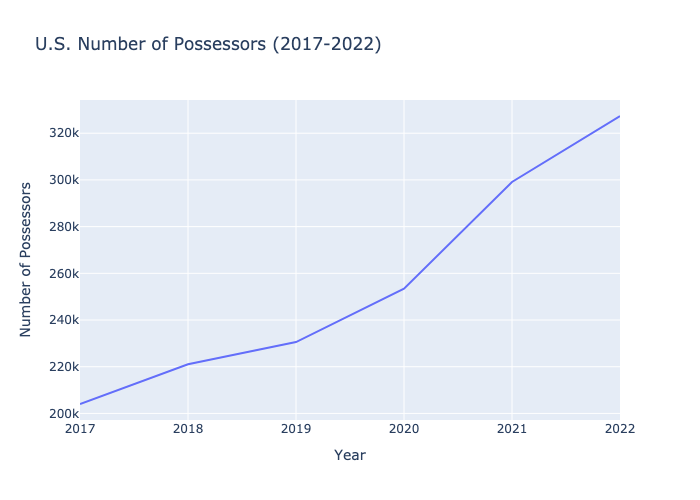

In [141]:
fig = px.line(us_ages.sum(), 
              labels={'value': 'Number of Possessors', 
                      'index': 'Year'}, 
              title='U.S. Number of Possessors (2017-2022)') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. 2022 Ages of Possessors

In [142]:
us_2022 = ages.loc[:, ['2022']]
us_2022 = pd.DataFrame(us_2022.sum(axis=1))
us_2022 = us_2022.rename(columns={0: '2022'})
us_2022 = us_2022.rename_axis(None)
us_2022 = us_2022.drop(['Average Age'])
us_2022.head()

2022
17 & Under  15651
18 to 21    44593
22 to 24    37563
25 to 30    64520
31 to 40    79879

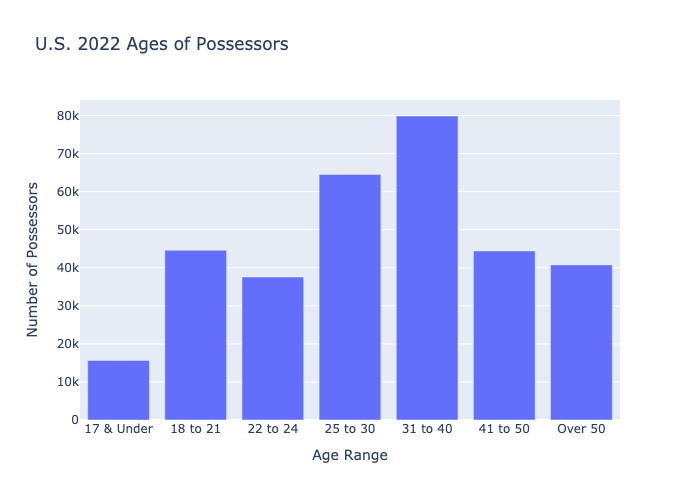

In [143]:
fig = px.bar(us_2022, 
             labels={'value': 'Number of Possessors', 
                     'index': 'Age Range'}, 
             title='U.S. 2022 Ages of Possessors') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC Number of Possessors (2017-2022)

In [144]:
nc_ages = ages.loc[:, (['2017', '2018', '2019', '2020', '2021', '2022'], ['NORTH CAROLINA'])]
nc_ages.columns = nc_ages.columns.droplevel(1)
nc_ages = nc_ages.drop(['Average Age'])
nc_ages.head()

2017  2018  2019  2020  2021  2022
AGES                                          
17 & Under   332   343   407   449   587   722
18 to 21    1429  1359  1528  1867  2416  2765
22 to 24    1323  1315  1361  1545  2151  2295
25 to 30    2144  2474  2428  2614  3485  3526
31 to 40    1832  2047  2400  2553  3448  3803

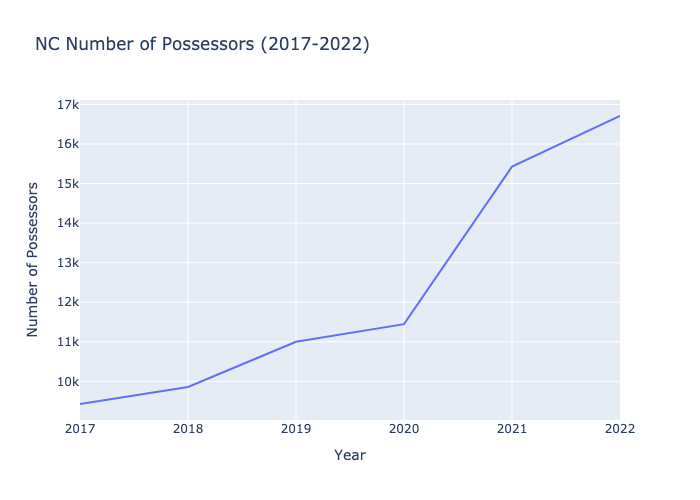

In [145]:
fig = px.line(nc_ages.sum(), 
              labels={'value': 'Number of Possessors', 
                      'index': 'Year'}, 
              title='NC Number of Possessors (2017-2022)') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC 2022 Ages of Possessors

In [146]:
nc_2022 = ages.loc[:, (['2022'], ['NORTH CAROLINA'])]
nc_2022.columns = nc_2022.columns.droplevel(1)
nc_2022 = nc_2022.rename_axis(None)
nc_2022 = nc_2022.drop(['Average Age'])
nc_2022.head()

2022
17 & Under   722
18 to 21    2765
22 to 24    2295
25 to 30    3526
31 to 40    3803

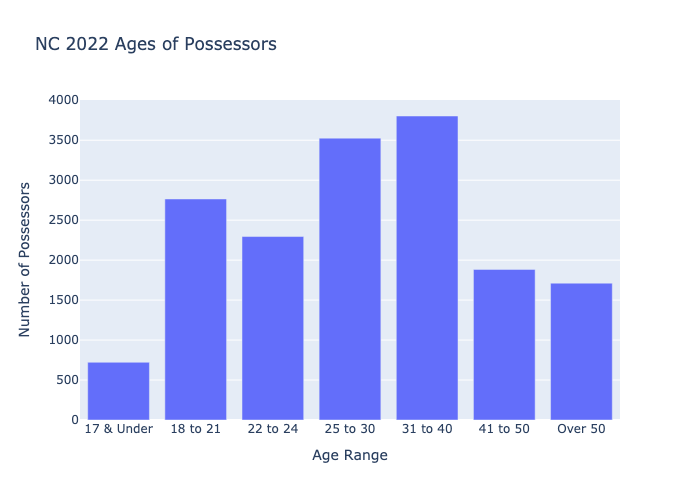

In [147]:
fig = px.bar(nc_2022, 
             labels={'value': 'Number of Possessors', 
                     'index': 'Age Range'}, 
             title='NC 2022 Ages of Possessors') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Time-to-Crime

In [148]:
ttc.head()

2017                                     \
                             ALABAMA ALASKA ARIZONA ARKANSAS CALIFORNIA   
TIME-TO-CRIME                                                             
Under 3 Months                 379.0   29.0   443.0     51.0     1143.0   
3 Months to Under 7 Months     347.0   33.0   261.0     66.0     1309.0   
7 Months to Under 1 Year       359.0   39.0   331.0     61.0     1391.0   
1 Year      to Under 2 Years   687.0   91.0   637.0    137.0     2657.0   
2 Years     to Under 3 Years   430.0   95.0   457.0    113.0     1906.0   

                                                            \
                             COLORADO CONNECTICUT DELAWARE   
TIME-TO-CRIME                                                
Under 3 Months                  289.0        23.0     75.0   
3 Months to Under 7 Months      253.0        15.0     57.0   
7 Months to Under 1 Year        263.0        17.0     62.0   
1 Year      to Under 2 Years    468.0        66.0    120.0   
2 Years     to Under 3 Years    352.0        55.0     68.0   

                                                           ...      2022  \
                             DISTRICT OF COLUMBIA FLORIDA  ... TENNESSEE   
TIME-TO-CRIME                                              ...             
Under 3 Months                               49.0  1056.0  ...    1115.0   
3 Months to Under 7 Months                   71.0  1004.0  ...    1084.0   
7 Months to Under 1 Year                     82.0  1031.0  ...    1338.0   
1 Year      to Under 2 Years                179.0  2076.0  ...    2536.0   
2 Years     to Under 3 Years                121.0  1444.0  ...    1614.0   

                                                                       \
                               TEXAS US VIRGIN ISLANDS   UTAH VERMONT   
TIME-TO-CRIME                                                           
Under 3 Months                5451.0               1.0  204.0    25.0   
3 Months to Under 7 Months    4451.0               2.0  190.0    12.0   
7 Months to Under 1 Year      4720.0               2.0  230.0    16.0   
1 Year      to Under 2 Years  8761.0               5.0  439.0    39.0   
2 Years     to Under 3 Years  5267.0               3.0  294.0    23.0   

                                                                          \
                             VIRGINIA WASHINGTON WEST VIRGINIA WISCONSIN   
TIME-TO-CRIME                                                              
Under 3 Months                 1127.0      290.0         135.0     700.0   
3 Months to Under 7 Months      992.0      309.0         122.0     615.0   
7 Months to Under 1 Year       1172.0      329.0          94.0     691.0   
1 Year      to Under 2 Years   2341.0      716.0         234.0    1309.0   
2 Years     to Under 3 Years   1452.0      474.0         161.0     719.0   

                                      
                             WYOMING  
TIME-TO-CRIME                         
Under 3 Months                  26.0  
3 Months to Under 7 Months      14.0  
7 Months to Under 1 Year        13.0  
1 Year      to Under 2 Years    45.0  
2 Years     to Under 3 Years    23.0  

[5 rows x 324 columns]

# U.S. 2017 Time-to-Crime

In [149]:
us_2017 = ttc.loc[:, ['2017']]
us_2017 = pd.DataFrame(us_2017.sum(axis=1))
us_2017 = us_2017.rename(columns={0: '2017'})
us_2017 = us_2017.rename_axis(None)
us_2017 = us_2017.iloc[:6]
us_2017.head()

2017
Under 3 Months                15341.0
3 Months to Under 7 Months    14015.0
7 Months to Under 1 Year      14572.0
1 Year      to Under 2 Years  28666.0
2 Years     to Under 3 Years  19948.0

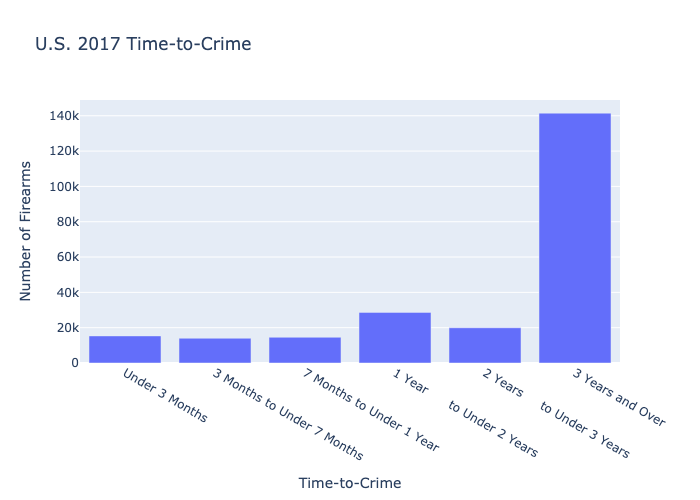

In [150]:
fig = px.bar(us_2017, 
             labels={'value': 'Number of Firearms', 
                     'index': 'Time-to-Crime'}, 
             title='U.S. 2017 Time-to-Crime') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. 2022 Time-to-Crime

In [151]:
us_2022 = ttc.loc[:, ['2022']]
us_2022 = pd.DataFrame(us_2022.sum(axis=1))
us_2022 = us_2022.rename(columns={0: '2022'})
us_2022 = us_2022.rename_axis(None)
us_2022 = us_2022.iloc[:6]
us_2022.head()

2022
Under 3 Months                33445.0
3 Months to Under 7 Months    30832.0
7 Months to Under 1 Year      35007.0
1 Year      to Under 2 Years  72567.0
2 Years     to Under 3 Years  43017.0

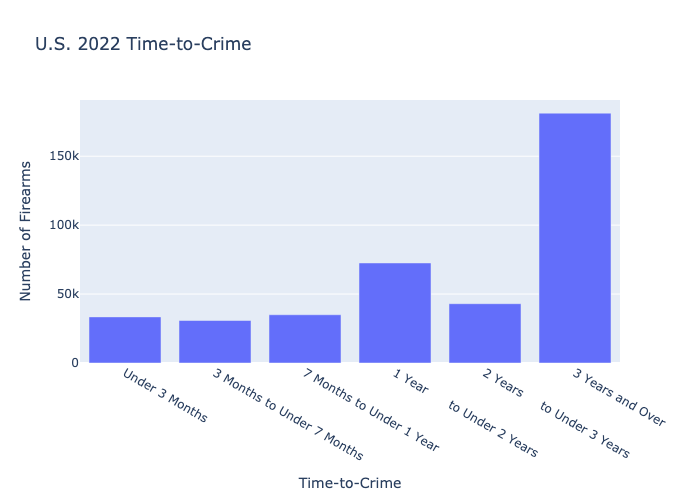

In [152]:
fig = px.bar(us_2022, 
             labels={'value': 'Number of Firearms', 
                     'index': 'Time-to-Crime'}, 
             title='U.S. 2022 Time-to-Crime') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC 2017 Time-to-Crime

In [153]:
nc_2017 = ttc.loc[:, (['2017'], ['NORTH CAROLINA'])]
nc_2017.columns = nc_2017.columns.droplevel(1)
nc_2017 = nc_2017.rename_axis(None)
nc_2017 = nc_2017.iloc[:6]
nc_2017.head()

2017
Under 3 Months                 677.0
3 Months to Under 7 Months     656.0
7 Months to Under 1 Year       639.0
1 Year      to Under 2 Years  1292.0
2 Years     to Under 3 Years   933.0

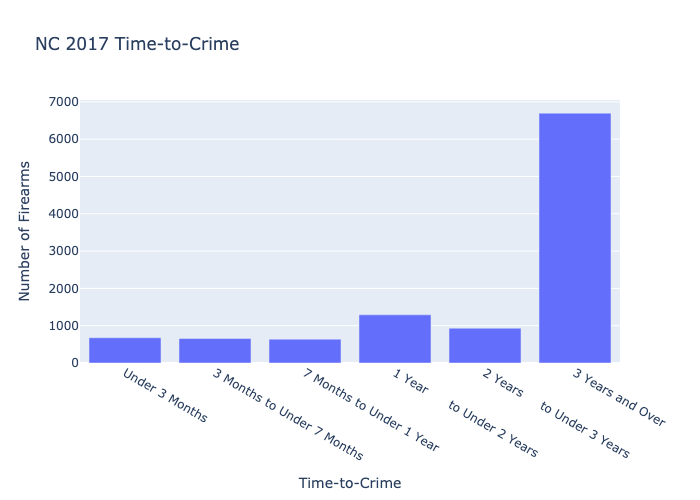

In [154]:
fig = px.bar(nc_2017, 
             labels={'value': 'Number of Firearms', 
                     'index': 'Time-to-Crime'}, 
             title='NC 2017 Time-to-Crime') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC 2022 Time-to-Crime

In [155]:
nc_2022 = ttc.loc[:, (['2022'], ['NORTH CAROLINA'])]
nc_2022.columns = nc_2022.columns.droplevel(1)
nc_2022 = nc_2022.rename_axis(None)
nc_2022 = nc_2022.iloc[:6]
nc_2022.head()

2022
Under 3 Months                1809.0
3 Months to Under 7 Months    1756.0
7 Months to Under 1 Year      1906.0
1 Year      to Under 2 Years  3944.0
2 Years     to Under 3 Years  2264.0

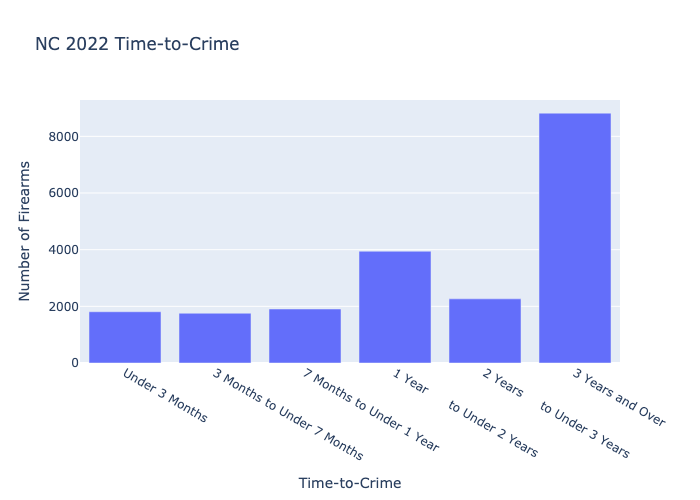

In [156]:
fig = px.bar(nc_2022, 
             labels={'value': 'Number of Firearms', 
                     'index': 'Time-to-Crime'}, 
             title='NC 2022 Time-to-Crime') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# Gun Types

In [157]:
types.head()

2017                                              \
0                  ALABAMA ALASKA ARIZONA ARKANSAS CALIFORNIA COLORADO   
TYPES                                                                    
Any Other Weapon       2.0    0.0    28.0      0.0        6.0      6.0   
Combination            5.0    1.0     2.0      1.0       12.0      3.0   
Derringer             47.0    5.0    35.0     12.0      265.0     23.0   
Destructive Device     1.0    0.0     3.0      0.0        5.0      0.0   
Flare Gun              0.0    0.0     2.0      0.0        1.0      0.0   

                                                                      ...  \
0                  CONNECTICUT DELAWARE DISTRICT OF COLUMBIA FLORIDA  ...   
TYPES                                                                 ...   
Any Other Weapon           0.0      0.0                  0.0     5.0  ...   
Combination                2.0      0.0                  0.0     9.0  ...   
Derringer                  9.0      4.0                  8.0   141.0  ...   
Destructive Device         0.0      1.0                  0.0     3.0  ...   
Flare Gun                  1.0      0.0                  1.0     1.0  ...   

                    2022                                                     \
0                  TEXAS US VIRGIN ISLANDS UTAH VERMONT VIRGINIA WASHINGTON   
TYPES                                                                         
Any Other Weapon     NaN               NaN  NaN     NaN      NaN        NaN   
Combination          NaN               NaN  NaN     NaN      NaN        NaN   
Derringer            NaN               NaN  NaN     NaN      NaN        NaN   
Destructive Device   NaN               NaN  NaN     NaN      NaN        NaN   
Flare Gun            NaN               NaN  NaN     NaN      NaN        NaN   

                                                          
0                  WEST VIRGINIA WISCONSIN WYOMING TOTAL  
TYPES                                                     
Any Other Weapon             NaN       NaN     NaN   NaN  
Combination                  NaN       NaN     NaN   NaN  
Derringer                    NaN       NaN     NaN   NaN  
Destructive Device           NaN       NaN     NaN   NaN  
Flare Gun                    NaN       NaN     NaN   NaN  

[5 rows x 330 columns]

# U.S. Number of Guns (2017-2022)

In [158]:
us_types = types.groupby(axis=1, level=0).sum()
us_types.head()

2017  2018  2019  2020  2021  2022
TYPES                                                   
Any Other Weapon     216.0   0.0   0.0   0.0   0.0   0.0
Combination          268.0   0.0   0.0   0.0   0.0   0.0
Derringer           4174.0   0.0   0.0   0.0   0.0   0.0
Destructive Device   104.0   0.0   0.0   0.0   0.0   0.0
Flare Gun             32.0   0.0   0.0   0.0   0.0   0.0

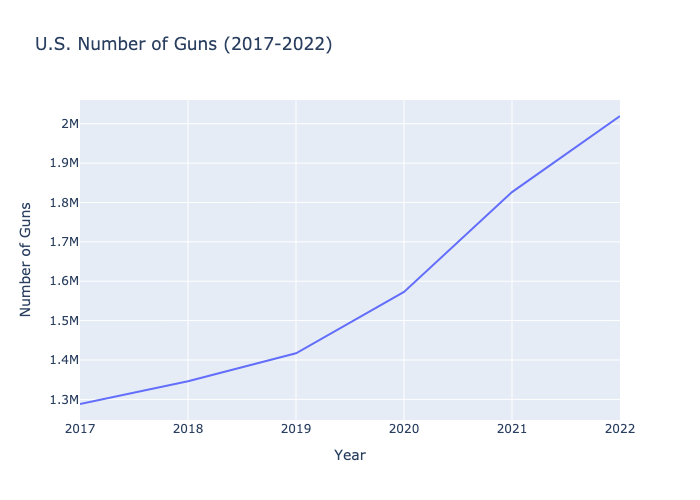

In [159]:
fig = px.line(us_types.sum(), 
              labels={'value': 'Number of Guns', 
                      'index': 'Year'}, 
              title='U.S. Number of Guns (2017-2022)') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# U.S. 2022 Gun Types

In [160]:
us_2022 = types.loc[:, ['2022']]
us_2022 = pd.DataFrame(us_2022.sum(axis=1))
us_2022 = us_2022.rename(columns={0: '2022'})
us_2022 = us_2022.rename_axis(None)
us_2022 = us_2022.dropna()
us_2022 = us_2022[us_2022['2022'] != 0]
us_2022 = us_2022.drop(['TOTAL'])
us_2022.head()

2022
ANY OTHER WEAPONS     232.0
COMBINATIONS          336.0
DERRINGERS           3740.0
DESTRUCTIVE DEVICES   100.0
FLARE GUNS             36.0

In [161]:
us_old_total = us_2022['2022'].sum()
us_2022 = us_2022[((us_2022['2022'] / us_2022['2022'].sum()) * 100) > 1.0]
us_new_total = us_2022['2022'].sum()
us_2022.loc['OTHER'] = us_old_total - us_new_total
us_2022.head()

2022
PISTOLS    753246.0
REVOLVERS   75278.0
RIFLES     106922.0
SHOTGUNS    52910.0
OTHER       21408.0

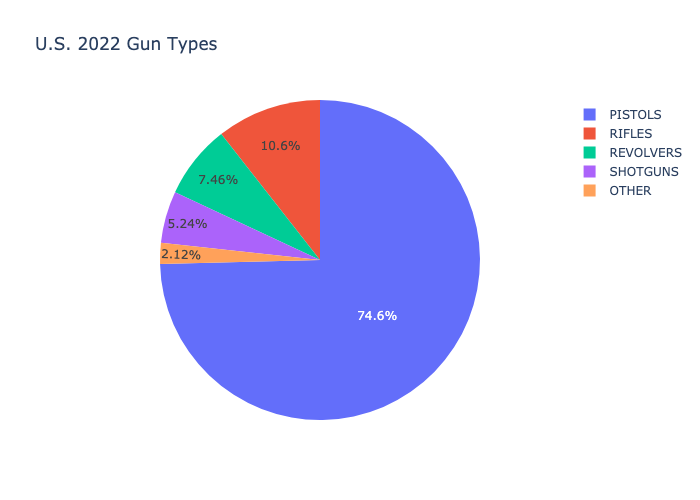

In [162]:
fig = px.pie(us_2022, 
             values='2022', 
             names=us_2022.index, 
             title='U.S. 2022 Gun Types')

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC Number of Guns (2017-2022)

In [163]:
nc_types = types.loc[:, (['2017', '2018', '2019', '2020', '2021', '2022'], ['NORTH CAROLINA'])]
nc_types.columns = nc_types.columns.droplevel(1)
nc_types.head()

2017  2018  2019  2020  2021  2022
TYPES                                                 
Any Other Weapon     2.0   NaN   NaN   NaN   NaN   NaN
Combination          4.0   NaN   NaN   NaN   NaN   NaN
Derringer           93.0   NaN   NaN   NaN   NaN   NaN
Destructive Device   0.0   NaN   NaN   NaN   NaN   NaN
Flare Gun            0.0   NaN   NaN   NaN   NaN   NaN

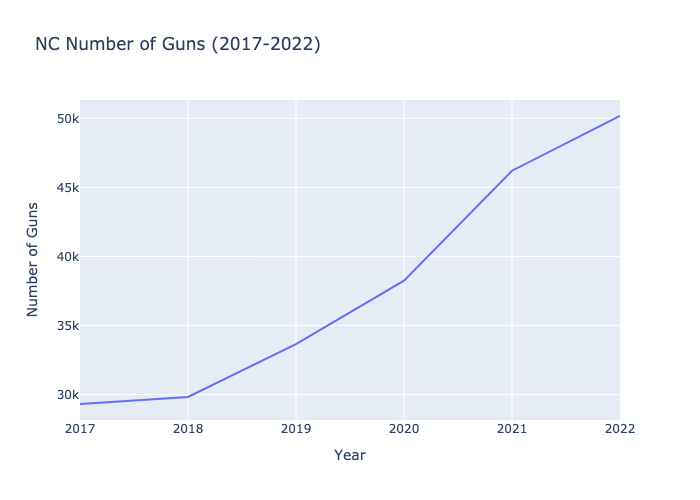

In [164]:
fig = px.line(nc_types.sum(), 
              labels={'value': 'Number of Guns', 
                      'index': 'Year'}, 
              title='NC Number of Guns (2017-2022)') 

fig.update_layout(showlegend=False)

img_bytes = fig.to_image(format='png')
Image(img_bytes)

# NC 2022 Gun Types

In [165]:
nc_2022 = types.loc[:, (['2022'], ['NORTH CAROLINA'])]
nc_2022.columns = nc_2022.columns.droplevel(1)
nc_2022 = nc_2022.rename_axis(None)
nc_2022 = nc_2022.dropna()
nc_2022 = nc_2022[nc_2022['2022'] != 0]
nc_2022 = nc_2022.drop(['TOTAL'])
nc_2022.head()

2022
ANY OTHER WEAPONS      3.0
COMBINATIONS           7.0
DERRINGERS           122.0
MACHINEGUNS          223.0
PISTOLS            18389.0

In [166]:
nc_old_total = nc_2022['2022'].sum()
nc_2022 = nc_2022[((nc_2022['2022'] / nc_2022['2022'].sum()) * 100) > 1.0]
nc_new_total = nc_2022['2022'].sum()
nc_2022.loc['OTHER'] = nc_old_total - nc_new_total
nc_2022.head()

2022
PISTOLS    18389.0
REVOLVERS   1817.0
RIFLES      2856.0
SHOTGUNS    1585.0
OTHER        438.0

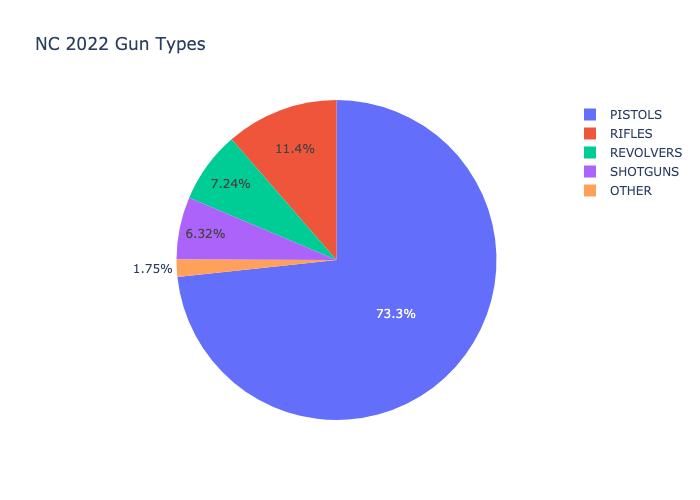

In [167]:
fig = px.pie(nc_2022, 
             values='2022', 
             names=nc_2022.index, 
             title='NC 2022 Gun Types')

img_bytes = fig.to_image(format='png')
Image(img_bytes)